In [1]:
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import glob
import h5py

In [4]:
import os
import sys
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, random_split

# sklearn functions
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split, KFold, GroupShuffleSplit

# load functions from nitorch
sys.path.insert(0,"/analysis/fabiane/phd/nitorch/")
from nitorch.data import load_nifti
from nitorch.transforms import  ToTensor, SagittalTranslate, SagittalFlip, \
                                AxialTranslate, normalization_factors, Normalize, \
                                IntensityRescale
from nitorch.callbacks import EarlyStopping, ModelCheckpoint
from nitorch.trainer import Trainer
from nitorch.initialization import weights_init
from nitorch.metrics import balanced_accuracy, sensitivity, specificity
from nitorch.utils import count_parameters

In [5]:
import random
from models_ukb import ModelLiu
from hyperparameter_options import params_liu as hyperparams

In [6]:
torch.__version__

'1.0.0'

In [7]:
gpu = 4
multi_gpus = None #[5, 6]
zero_one_normalize = False
dtype = np.float64

In [8]:
# load mask
mask = None

In [9]:
table = "/ritter/share/projects/UKbiobank/Eitel_ICD/tables/participants_transMRI_T1-ICD10_G_binary-under.csv"

In [10]:
# load dataset and show first 5 rows
df = pd.read_csv(table)
df.head()

,Unnamed: 0,PTID,file_path,T2,Encoded anonymised participant ID,T1 structural brain images - NIFTI Index: 2.0,T2 FLAIR structural brain images - NIFTI Index: 2.0,Functional brain images - task - NIFTI Index: 2.0,Sex,ICD10_F_cat,...,Illness2Years2,MoodSwings_diff,Sensitivity_diff,Nervous_diff,Worrier_diff,TenseHighlyStung_diff,Loneliness_diff,RiskTaking_diff,Happiness_diff,FamilyRelation_diff
0,0,1100042,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1100042,20252_2_0,20253_2_0,20249_2_0,Female,[],...,0None,0YY,0YY,1NN,0YY,1NN,1NN,1NN,9Na,9Na
1,1,1100675,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1100675,20252_2_0,20253_2_0,20249_2_0,Female,[],...,0None,1NN,9else,1NN,0YY,9else,1NN,9else,9Na,9Na
2,2,1180478,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1180478,20252_2_0,20253_2_0,20249_2_0,Female,[],...,0None,0YY,0YY,1NN,2YN,0YY,1NN,0YY,9Na,9Na
3,3,1112124,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1112124,20252_2_0,20253_2_0,20249_2_0,Male,[],...,0None,9else,0YY,0YY,0YY,9else,1NN,1NN,9Na,9Na
4,4,1148079,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1148079,20252_2_0,20253_2_0,20249_2_0,Female,[],...,3SitY,3NY,0YY,3NY,0YY,3NY,1NN,1NN,9Na,9Na


In [11]:
# shuffle the dataset
df = df.sample(frac=1, random_state=23) # NOTE: use all!
df.head()

,Unnamed: 0,PTID,file_path,T2,Encoded anonymised participant ID,T1 structural brain images - NIFTI Index: 2.0,T2 FLAIR structural brain images - NIFTI Index: 2.0,Functional brain images - task - NIFTI Index: 2.0,Sex,ICD10_F_cat,...,Illness2Years2,MoodSwings_diff,Sensitivity_diff,Nervous_diff,Worrier_diff,TenseHighlyStung_diff,Loneliness_diff,RiskTaking_diff,Happiness_diff,FamilyRelation_diff
791,791,1109592,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1109592,20252_2_0,20253_2_0,20249_2_0,Female,[],...,0None,1NN,3NY,1NN,0YY,1NN,1NN,3NY,MH.VH,VH.VH
1705,1705,1197086,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1197086,20252_2_0,20253_2_0,20249_2_0,Male,[],...,0None,0YY,0YY,9else,2YN,3NY,0YY,1NN,9Na,9Na
167,167,1092621,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1092621,20252_2_0,20253_2_0,20249_2_0,Female,[],...,"4SitR,5DocR",2YN,1NN,1NN,1NN,1NN,3NY,1NN,9Na,9Na
331,331,1037619,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1037619,20252_2_0,20253_2_0,20249_2_0,Male,[],...,0None,2YN,0YY,3NY,3NY,1NN,1NN,0YY,9Na,9Na
651,651,1161652,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1161652,20252_2_0,20253_2_0,20249_2_0,Male,[],...,0None,3NY,3NY,1NN,0YY,1NN,3NY,2YN,9Na,9Na


In [12]:
df.groupby(["Sex"])["PTID"].count()

Sex
Female    1005
Male       849
Name: PTID, dtype: int64

In [47]:
# instantiate ToTensor object
to_tensor = ToTensor()

def draw_patch(img, patch_size, all_locs=False):
    """
    Draw a patch from the image based on the specified size. 
    By default draws randomly but setting all_locs = True
    returns all possible patches in a batch.
    
    Params:
        all_locs - set to True returns all patches
    """
    img_shape = img.shape
    patch_pot_locs = [[0, int(patch_size[dim]*0.5), patch_size[dim]] for dim in range(len(img_shape))]
    # check correct size
    for dim in range(len(img_shape)):
        assert(np.max(patch_pot_locs[dim]) + patch_size[dim] <= img_shape[dim])
        
    if all_locs:
        # return all locations
        patches = []
        #num_patches_per_dim = [reduce((lambda x, y: x*y), dim_list) for dim_list in patch_pot_locs]
        #num_patches_per_dim = [len(dim_list) for dim_list in patch_pot_locs]
        all_locs = list(product(*patch_pot_locs))
        for patch_locs in all_locs:
            patch = img[patch_locs[0]:patch_locs[0]+patch_size[0],
                    patch_locs[1]:patch_locs[1]+patch_size[1],
                    patch_locs[2]:patch_locs[2]+patch_size[2]]
            patches.append(patch)
        return patches
    else:
        # return random location
        patch_locs = [random.choice(patch_pot_locs[dim]) for dim in range(len(img_shape))]
        #patch_locs = [patch_pot_locs[dim][1] for dim in range(len(img_shape))] ### Use the same patch each round
        patch = img[patch_locs[0]:patch_locs[0]+patch_size[0],
                    patch_locs[1]:patch_locs[1]+patch_size[1],
                    patch_locs[2]:patch_locs[2]+patch_size[2]]
        return patch

class UKBGDataset(Dataset):
    def __init__(self, dataframe, transform=None, mask=None, z_factor=None, patched=False, all_locs=False):
        self.df = dataframe
        self.transform = transform
        self.mask = mask
        self.z_factor = z_factor
        self.patched = patched
        self.all_locs = all_locs
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        if isinstance(idx, torch.FloatTensor):
            idx = idx.item()
        idx = int(idx)
        
        path = self.df.iloc[idx]['file_path']
        path = path.replace("/analysis/ritter", "/ritter/share")
        image = load_nifti(path, mask=self.mask, z_factor=self.z_factor)
        
        label = self.df.iloc[idx]['Sex']
        label = torch.FloatTensor([int(label == "Male")])
        
        if self.transform:
            image = self.transform(image)
        
        if self.patched:
            reshaped_img = image[15:160,25:196,5:155]
            #reshaped_img = image[8:85,10:105,5:85]
            patch_size = [s//k for s, k in zip(reshaped_img.shape, [2, 3, 2])]
            image = draw_patch(reshaped_img, patch_size, all_locs=self.all_locs)
        
        # normalize by max
        image /= np.max(image)
        
        image = to_tensor(image)
            
        sample = {"image" : image,
                 "label" : label}
        return sample

In [14]:
augmentations = [SagittalTranslate(dist=(4))]

In [15]:
ukb_data_train = UKBGDataset(df, transform=transforms.Compose(augmentations), mask=mask, patched=False)#, z_factor=0.525)

In [16]:
img = ukb_data_train[0]["image"]

In [17]:
img.shape

torch.Size([1, 182, 218, 182])

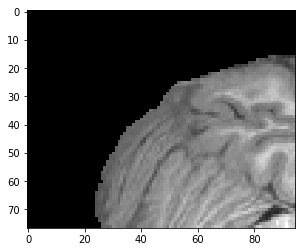

In [18]:
plt.imshow(img[0][8:85,10:105,50], cmap='gray')

# Define the classifier

In [19]:
def pick_model(name):
    if name == "ModelA":
        net = ModelA()
    elif name == "ModelB":
        net = ModelB()
    elif name == "ModelAPIF":
        net = ModelAPIF()
    elif name == "ModelBPIF":
        net = ModelBPIF()
    elif name == "ModelLiu":
        net = ModelLiu()
    return net

def update_outer_scores(outer_fold_best, report, retain_metric, selected_hyperparams, inner_fold_idx):
    outer_fold_best["final_acc"] = report["val_metrics"][retain_metric][-1]
    print(len(report["val_metrics"][retain_metric]))
    print(report["val_metrics"][retain_metric])
    outer_fold_best["best_acc"] = np.max(report["val_metrics"][retain_metric]) # removed starting from ignore epochs as we do not run validation in every iteration
    outer_fold_best["final_iter"] = len(report["val_metrics"][retain_metric])
    outer_fold_best["best_iter"] = outer_fold_best["final_iter"] - np.argmax(np.flip(np.copy(report["val_metrics"][retain_metric]), axis=0))
    outer_fold_best["params"] = selected_hyperparams
    outer_fold_best["inner_fold_idx"] = inner_fold_idx
    return outer_fold_best

# Training

In [20]:
def run(
    net,
    data,
    shape,
    callbacks=[],
    augmentations=[],
    masked=False,
    metrics=[],
    k_folds=None,
    b=None,
    num_epochs=35,
    retain_metric=None
):      
   
    fold_metric = []
    all_outer_bests = []
    best_metric = []
    models = []
    fold = 0
    initial_prepend = None
    
    random_states = np.arange(20, 22) # will be used again to split in testing phase
    
    for outer_fold, r in enumerate(random_states):
        print("###### Starting outer fold {}".format(outer_fold))
        # load new random data split each outer fold
        # separate new test set
        no_test_df = data.sample(frac=0.8, random_state=r) # split according 
         # split train/validation
        train_df = no_test_df.sample(frac=0.8, random_state=32) # can be the same r at each inner fold
        val_df = no_test_df[~no_test_df["PTID"].isin(train_df["PTID"])]
        
        if zero_one_normalize:
            intensity = IntensityRescale()
            ukb_data_train = UKBGDataset(train_df, transform=transforms.Compose(augmentations + [intensity]), mask=mask, patched=True)
            ukb_data_val = UKBGDataset(val_df, transform=transforms.Compose([intensity]), mask=mask, patched=True)
        else:
            ukb_data_train = UKBGDataset(train_df, transform=transforms.Compose(augmentations), mask=mask, patched=True)
            ukb_data_val = UKBGDataset(val_df, transform=None, mask=mask, patched=True)
        
        print(len(ukb_data_train))
        print(len(ukb_data_val))
        
        print("Shuffled the data..")
        
        outer_fold_best = {
            "final_acc" : 0,
            "best_acc" : 0,
            "final_iter" : 0,
            "best_iter" : 0,
            "params" : {},
            "inner_fold_idx" : 0
        }
        
        for inner_fold in range(5):
            print("###### Starting inner fold {}".format(inner_fold))
            # sample randomly from the hyperparameter options each inner fold
            model_name = "ModelLiu"
            b = random.choice(hyperparams["batch_size"])
            patience = random.choice(hyperparams["patience"]["small"])
            lr = random.choice(hyperparams["lr"])

            selected_hyperparams = {
                "model" : model_name,
                "batch_size" : b,
                "patience" : patience,
                "lr" : lr
                }
            print(selected_hyperparams)   
            
            # load model
            if multi_gpus is None:
                net = pick_model(model_name).cuda(gpu)
            else:
                net = torch.nn.DataParallel(pick_model(model_name), device_ids=multi_gpus).cuda(gpu)
            print("Trainable model parameters: {}".format(count_parameters(net)))
        
            callbacks = [EarlyStopping(patience=patience, ignore_before=ignore_epochs, retain_metric="loss", mode='min'),
                         ModelCheckpoint(path=output_dir,
                                         prepend="outer_{}_inner_{}".format(outer_fold, inner_fold),
                                         store_best=True,
                                         ignore_before=ignore_epochs,
                                         retain_metric=retain_metric)]
        
            # add current fold number to model checkpoint path
            if callbacks is not None:
                for idx, callback in enumerate(callbacks):
                    if isinstance(callback, ModelCheckpoint):
                        if initial_prepend is None:
                            initial_prepend = callbacks[idx].prepend
                        callbacks[idx].prepend = initial_prepend + "cv_fold_{}_".format(fold)
                        initial_prepend = None
            fold += 1

            # set optimizer
            wd = 1e-5 #0.008
            criterion = nn.BCEWithLogitsLoss().cuda(gpu)
            optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)

            train_loader = DataLoader(
                ukb_data_train, batch_size=b, shuffle=True, num_workers=4
            )

            val_loader = DataLoader(
                ukb_data_val, batch_size=2, shuffle=True, num_workers=0
            )

            img = next(iter(train_loader))["image"][0]
            print(img.shape)
            plt.imshow(img[0][:,:,18], cmap='gray')
            plt.show()

            trainer = Trainer(
                net,
                criterion,
                optimizer,
                metrics=metrics,
                callbacks=callbacks,
                device=gpu
            )
            # train model and store results
            net, report = trainer.train_model(
                train_loader,
                val_loader,
                num_epochs=num_epochs,
                show_train_steps=10,
                show_validation_epochs=10,
            )
            # append validation score of the retain metric
            if isinstance(retain_metric, str):
                # use the average of the last 10 epochs
                best_val = np.mean(report["val_metrics"][retain_metric][-10:])
                fold_metric.append(report["val_metrics"][retain_metric][-1])
                best_metric.append(best_val)
                # replace best model for this outer_fold in case of improvement
                #if report["val_metrics"][retain_metric][-1] > outer_fold_best["final_acc"]:
                if report["val_metrics"][retain_metric][-1] > outer_fold_best["final_acc"]:
                    update_outer_scores(outer_fold_best, report, retain_metric, selected_hyperparams, inner_fold)
            else:
                # use the average of the last 10 epochs
                best_val = np.mean(report["val_metrics"][retain_metric.__name__][-10:])
                fold_metric.append(report["val_metrics"][retain_metric.__name__][-1])
                best_metric.append(best_val)
                # replace best model for this outer_fold in case of improvement
                #if report["val_metrics"][retain_metric.__name__][-1] > outer_fold_best["final_acc"]:
                if best_val > outer_fold_best["final_acc"]:
                    update_outer_scores(outer_fold_best, report, retain_metric.__name__, selected_hyperparams, inner_fold)

            models.append(net)
            print("Finished inner fold.")

            # visualize result
            trainer.visualize_training(report, metrics)
            trainer.evaluate_model(val_loader, gpu)
        print("Finished outer fold.")
        print(outer_fold_best)
        all_outer_bests.append(outer_fold_best)

    print("################################")
    print("################################")
    print("All accuracies: {}".format(fold_metric))
    print("Best accuracies mean: {} All :{}".format(np.mean(best_metric), best_metric))
    print(all_outer_bests)
    return fold_metric, models

In [21]:
num_epochs = 200
min_iters = 3
ignore_epochs = 130
normalize = False
retain_metric = balanced_accuracy
metrics = [accuracy_score, balanced_accuracy]

In [22]:
output_dir = "/ritter/share/projects/Methods/Eitel_local_filter/experiments_submission/models/UKB/full_set/10xrandom_splits/liu_patches/"

###### Starting outer fold 0
1186
297
Shuffled the data..
###### Starting inner fold 0
{'model': 'ModelLiu', 'batch_size': 32, 'patience': 16, 'lr': 5e-05}
Trainable model parameters: 116001
torch.Size([1, 72, 57, 75])


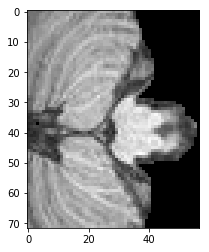

/home/fabiane/anaconda2/envs/mort1/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


[0,    10] loss: 0.70084
[0,    20] loss: 0.70326
[0,    30] loss: 0.69563
Time elapsed: 0h:2m:5s
train accuracy_score: 46.96 %
train balanced_accuracy: 50.49 %
val accuracy_score: 50.17 %
val balanced_accuracy: 48.15 %
Val loss: 0.692575
[1,    10] loss: 0.68703
[1,    20] loss: 0.69219
[1,    30] loss: 0.68748
Time elapsed: 0h:6m:31s
train accuracy_score: 52.70 %
train balanced_accuracy: 49.04 %
[2,    10] loss: 0.68760
[2,    20] loss: 0.68954
[2,    30] loss: 0.69616
Time elapsed: 0h:8m:30s
train accuracy_score: 53.96 %
train balanced_accuracy: 49.78 %
[3,    10] loss: 0.69243
[3,    20] loss: 0.68929
[3,    30] loss: 0.67942
Time elapsed: 0h:10m:25s
train accuracy_score: 53.96 %
train balanced_accuracy: 49.79 %
[4,    10] loss: 0.69223
[4,    20] loss: 0.68787
[4,    30] loss: 0.68397
Time elapsed: 0h:12m:19s
train accuracy_score: 54.13 %
train balanced_accuracy: 49.92 %
[5,    10] loss: 0.68535
[5,    20] loss: 0.68595
[5,    30] loss: 0.68958
Time elapsed: 0h:14m:12s
train accur

[47,    30] loss: 0.68019
Time elapsed: 1h:41m:38s
train accuracy_score: 55.40 %
train balanced_accuracy: 52.57 %
[48,    10] loss: 0.68377
[48,    20] loss: 0.69162
[48,    30] loss: 0.68953
Time elapsed: 1h:43m:28s
train accuracy_score: 54.38 %
train balanced_accuracy: 52.18 %
[49,    10] loss: 0.68781
[49,    20] loss: 0.69153
[49,    30] loss: 0.69110
Time elapsed: 1h:45m:18s
train accuracy_score: 55.06 %
train balanced_accuracy: 54.12 %
[50,    10] loss: 0.69072
[50,    20] loss: 0.69023
[50,    30] loss: 0.68691
Time elapsed: 1h:47m:9s
train accuracy_score: 54.22 %
train balanced_accuracy: 51.89 %
val accuracy_score: 57.58 %
val balanced_accuracy: 53.70 %
Val loss: 0.677880
[51,    10] loss: 0.68534
[51,    20] loss: 0.67793
[51,    30] loss: 0.68618
Time elapsed: 1h:50m:44s
train accuracy_score: 55.56 %
train balanced_accuracy: 52.76 %
[52,    10] loss: 0.69815
[52,    20] loss: 0.67019
[52,    30] loss: 0.68379
Time elapsed: 1h:52m:33s
train accuracy_score: 55.31 %
train balanc

Time elapsed: 3h:18m:28s
train accuracy_score: 57.42 %
train balanced_accuracy: 55.81 %
[95,    10] loss: 0.67009
[95,    20] loss: 0.66269
[95,    30] loss: 0.67876
Time elapsed: 3h:20m:23s
train accuracy_score: 58.18 %
train balanced_accuracy: 56.23 %
[96,    10] loss: 0.67983
[96,    20] loss: 0.67192
[96,    30] loss: 0.67385
Time elapsed: 3h:22m:15s
train accuracy_score: 55.82 %
train balanced_accuracy: 54.90 %
[97,    10] loss: 0.66801
[97,    20] loss: 0.66117
[97,    30] loss: 0.66842
Time elapsed: 3h:24m:13s
train accuracy_score: 59.19 %
train balanced_accuracy: 58.14 %
[98,    10] loss: 0.68217
[98,    20] loss: 0.65880
[98,    30] loss: 0.66626
Time elapsed: 3h:26m:5s
train accuracy_score: 57.59 %
train balanced_accuracy: 56.08 %
[99,    10] loss: 0.66304
[99,    20] loss: 0.65444
[99,    30] loss: 0.65659
Time elapsed: 3h:28m:2s
train accuracy_score: 59.27 %
train balanced_accuracy: 57.88 %
[100,    10] loss: 0.65969
[100,    20] loss: 0.67039
[100,    30] loss: 0.66407
Tim

[141,    10] loss: 0.64074
[141,    20] loss: 0.64578
[141,    30] loss: 0.64039
Time elapsed: 5h:0m:19s
train accuracy_score: 60.96 %
train balanced_accuracy: 60.22 %
[142,    10] loss: 0.62628
[142,    20] loss: 0.65662
[142,    30] loss: 0.63047
Time elapsed: 5h:2m:11s
train accuracy_score: 63.58 %
train balanced_accuracy: 63.01 %
[143,    10] loss: 0.64254
[143,    20] loss: 0.65222
[143,    30] loss: 0.65711
Time elapsed: 5h:4m:4s
train accuracy_score: 62.39 %
train balanced_accuracy: 61.33 %
[144,    10] loss: 0.65986
[144,    20] loss: 0.62640
[144,    30] loss: 0.65610
Time elapsed: 5h:6m:0s
train accuracy_score: 64.00 %
train balanced_accuracy: 63.30 %
[145,    10] loss: 0.64201
[145,    20] loss: 0.65965
[145,    30] loss: 0.63235
Time elapsed: 5h:7m:57s
train accuracy_score: 65.01 %
train balanced_accuracy: 64.00 %
[146,    10] loss: 0.67383
[146,    20] loss: 0.64645
[146,    30] loss: 0.62940
Time elapsed: 5h:9m:48s
train accuracy_score: 62.73 %
train balanced_accuracy: 61

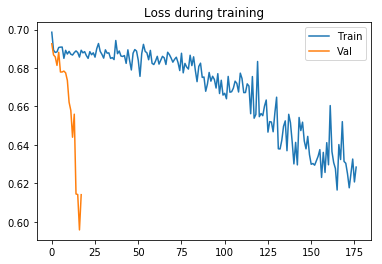

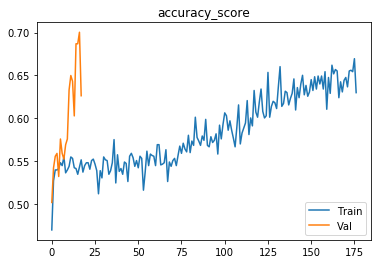

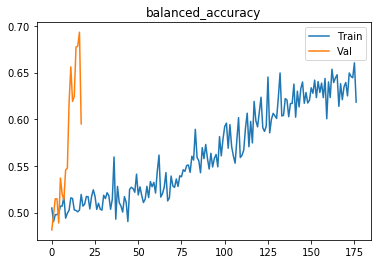

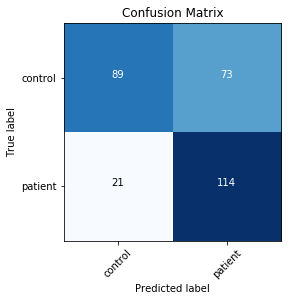

###### Starting inner fold 1
{'model': 'ModelLiu', 'batch_size': 32, 'patience': 12, 'lr': 0.0001}
Trainable model parameters: 116001
torch.Size([1, 72, 57, 75])


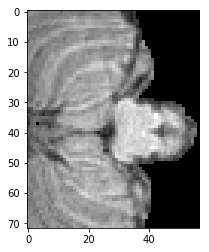

[0,    10] loss: 0.70202
[0,    20] loss: 0.69785
[0,    30] loss: 0.69480
Time elapsed: 0h:1m:57s
train accuracy_score: 47.64 %
train balanced_accuracy: 48.48 %
val accuracy_score: 54.55 %
val balanced_accuracy: 50.00 %
Val loss: 0.688839
[1,    10] loss: 0.69150
[1,    20] loss: 0.68968
[1,    30] loss: 0.67790
Time elapsed: 0h:5m:45s
train accuracy_score: 54.38 %
train balanced_accuracy: 50.41 %
[2,    10] loss: 0.70384
[2,    20] loss: 0.69446
[2,    30] loss: 0.69486
Time elapsed: 0h:7m:41s
train accuracy_score: 50.93 %
train balanced_accuracy: 48.88 %
[3,    10] loss: 0.68825
[3,    20] loss: 0.70059
[3,    30] loss: 0.68844
Time elapsed: 0h:9m:39s
train accuracy_score: 54.13 %
train balanced_accuracy: 50.05 %
[4,    10] loss: 0.67996
[4,    20] loss: 0.68696
[4,    30] loss: 0.69529
Time elapsed: 0h:11m:31s
train accuracy_score: 55.65 %
train balanced_accuracy: 51.67 %
[5,    10] loss: 0.68793
[5,    20] loss: 0.69627
[5,    30] loss: 0.68523
Time elapsed: 0h:13m:26s
train accur

[47,    30] loss: 0.67661
Time elapsed: 1h:41m:52s
train accuracy_score: 57.50 %
train balanced_accuracy: 57.51 %
[48,    10] loss: 0.64306
[48,    20] loss: 0.65674
[48,    30] loss: 0.66311
Time elapsed: 1h:43m:42s
train accuracy_score: 61.21 %
train balanced_accuracy: 60.21 %
[49,    10] loss: 0.67471
[49,    20] loss: 0.63371
[49,    30] loss: 0.65359
Time elapsed: 1h:45m:34s
train accuracy_score: 62.14 %
train balanced_accuracy: 60.96 %
[50,    10] loss: 0.70892
[50,    20] loss: 0.65559
[50,    30] loss: 0.63936
Time elapsed: 1h:47m:32s
train accuracy_score: 59.53 %
train balanced_accuracy: 58.04 %
val accuracy_score: 61.95 %
val balanced_accuracy: 59.20 %
Val loss: 0.643493
[51,    10] loss: 0.67315
[51,    20] loss: 0.65653
[51,    30] loss: 0.65846
Time elapsed: 1h:51m:14s
train accuracy_score: 60.03 %
train balanced_accuracy: 58.57 %
[52,    10] loss: 0.63962
[52,    20] loss: 0.65581
[52,    30] loss: 0.66205
Time elapsed: 1h:53m:4s
train accuracy_score: 62.82 %
train balanc

Time elapsed: 3h:19m:39s
train accuracy_score: 65.26 %
train balanced_accuracy: 65.15 %
[95,    10] loss: 0.64707
[95,    20] loss: 0.62254
[95,    30] loss: 0.64248
Time elapsed: 3h:21m:32s
train accuracy_score: 63.91 %
train balanced_accuracy: 63.19 %
[96,    10] loss: 0.63205
[96,    20] loss: 0.61723
[96,    30] loss: 0.66090
Time elapsed: 3h:23m:23s
train accuracy_score: 64.92 %
train balanced_accuracy: 63.68 %
[97,    10] loss: 0.63091
[97,    20] loss: 0.62957
[97,    30] loss: 0.67328
Time elapsed: 3h:25m:16s
train accuracy_score: 64.17 %
train balanced_accuracy: 64.04 %
[98,    10] loss: 0.62234
[98,    20] loss: 0.59177
[98,    30] loss: 0.61996
Time elapsed: 3h:27m:7s
train accuracy_score: 67.96 %
train balanced_accuracy: 66.81 %
[99,    10] loss: 0.63903
[99,    20] loss: 0.61500
[99,    30] loss: 0.61707
Time elapsed: 3h:28m:58s
train accuracy_score: 65.43 %
train balanced_accuracy: 64.50 %
[100,    10] loss: 0.60920
[100,    20] loss: 0.60089
[100,    30] loss: 0.65575
Ti

[141,    10] loss: 0.57920
[141,    20] loss: 0.60646
[141,    30] loss: 0.60861
Time elapsed: 4h:58m:54s
train accuracy_score: 67.37 %
train balanced_accuracy: 66.59 %
[142,    10] loss: 0.59937
[142,    20] loss: 0.57801
[142,    30] loss: 0.59189
Time elapsed: 5h:0m:50s
train accuracy_score: 68.21 %
train balanced_accuracy: 67.92 %
Early stopping in epoch 143
Total time elapsed: 5h:0m:50s
Writing model to disk...
Best result during training: 0.69. Saving model..
15
[0.5, 0.5, 0.51604938271604939, 0.57345679012345685, 0.56049382716049378, 0.59197530864197523, 0.6401234567901235, 0.67592592592592593, 0.66419753086419753, 0.64382716049382716, 0.75864197530864197, 0.65679012345679011, 0.69753086419753085, 0.66296296296296298, 0.68703703703703711]
Finished inner fold.


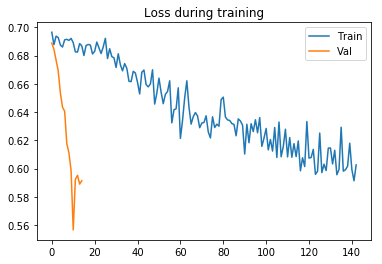

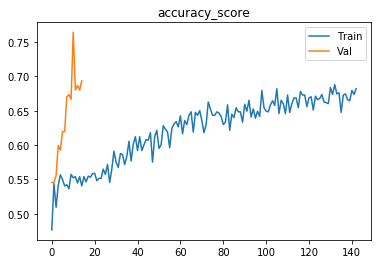

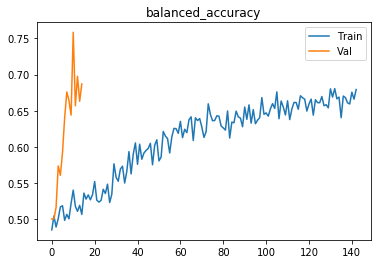

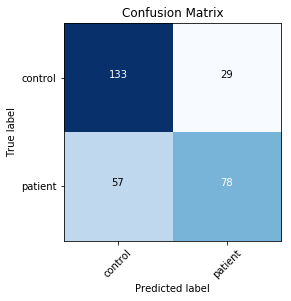

###### Starting inner fold 2
{'model': 'ModelLiu', 'batch_size': 16, 'patience': 16, 'lr': 5e-05}
Trainable model parameters: 116001
torch.Size([1, 72, 57, 75])


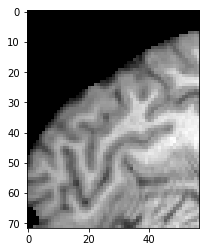

[0,    10] loss: 0.69572
[0,    20] loss: 0.69462
[0,    30] loss: 0.69192
[0,    40] loss: 0.68841
[0,    50] loss: 0.68370
[0,    60] loss: 0.69819
[0,    70] loss: 0.69111
Time elapsed: 0h:1m:51s
train accuracy_score: 52.11 %
train balanced_accuracy: 50.17 %
val accuracy_score: 54.55 %
val balanced_accuracy: 50.00 %
Val loss: 0.688994
[1,    10] loss: 0.68185
[1,    20] loss: 0.69239
[1,    30] loss: 0.69325
[1,    40] loss: 0.68265
[1,    50] loss: 0.70385
[1,    60] loss: 0.69912
[1,    70] loss: 0.68717
Time elapsed: 0h:5m:33s
train accuracy_score: 54.47 %
train balanced_accuracy: 50.20 %
[2,    10] loss: 0.69144
[2,    20] loss: 0.68860
[2,    30] loss: 0.68698
[2,    40] loss: 0.68452
[2,    50] loss: 0.70738
[2,    60] loss: 0.69062
[2,    70] loss: 0.68697
Time elapsed: 0h:7m:25s
train accuracy_score: 53.71 %
train balanced_accuracy: 49.50 %
[3,    10] loss: 0.68430
[3,    20] loss: 0.68982
[3,    30] loss: 0.70574
[3,    40] loss: 0.68250
[3,    50] loss: 0.69403
[3,    60] 

[30,    10] loss: 0.68881
[30,    20] loss: 0.68896
[30,    30] loss: 0.69527
[30,    40] loss: 0.68299
[30,    50] loss: 0.68038
[30,    60] loss: 0.68117
[30,    70] loss: 0.69434
Time elapsed: 1h:1m:22s
train accuracy_score: 54.97 %
train balanced_accuracy: 52.43 %
val accuracy_score: 55.22 %
val balanced_accuracy: 50.80 %
Val loss: 0.675982
[31,    10] loss: 0.70613
[31,    20] loss: 0.70589
[31,    30] loss: 0.67805
[31,    40] loss: 0.69240
[31,    50] loss: 0.68581
[31,    60] loss: 0.67377
[31,    70] loss: 0.70116
Time elapsed: 1h:4m:53s
train accuracy_score: 53.79 %
train balanced_accuracy: 50.28 %
[32,    10] loss: 0.68518
[32,    20] loss: 0.68370
[32,    30] loss: 0.67536
[32,    40] loss: 0.68023
[32,    50] loss: 0.68916
[32,    60] loss: 0.69146
[32,    70] loss: 0.69094
Time elapsed: 1h:6m:44s
train accuracy_score: 53.54 %
train balanced_accuracy: 49.93 %
[33,    10] loss: 0.68236
[33,    20] loss: 0.69429
[33,    30] loss: 0.68395
[33,    40] loss: 0.68438
[33,    50]

[59,    70] loss: 0.68498
Time elapsed: 1h:59m:28s
train accuracy_score: 56.83 %
train balanced_accuracy: 54.71 %
[60,    10] loss: 0.66966
[60,    20] loss: 0.66887
[60,    30] loss: 0.67118
[60,    40] loss: 0.67275
[60,    50] loss: 0.67032
[60,    60] loss: 0.68482
[60,    70] loss: 0.69267
Time elapsed: 2h:1m:19s
train accuracy_score: 58.01 %
train balanced_accuracy: 56.21 %
val accuracy_score: 55.56 %
val balanced_accuracy: 51.85 %
Val loss: 0.677262
[61,    10] loss: 0.66501
[61,    20] loss: 0.68806
[61,    30] loss: 0.66878
[61,    40] loss: 0.67931
[61,    50] loss: 0.67141
[61,    60] loss: 0.68838
[61,    70] loss: 0.69284
Time elapsed: 2h:4m:56s
train accuracy_score: 57.67 %
train balanced_accuracy: 55.94 %
[62,    10] loss: 0.68137
[62,    20] loss: 0.67852
[62,    30] loss: 0.65000
[62,    40] loss: 0.67950
[62,    50] loss: 0.65759
[62,    60] loss: 0.69493
[62,    70] loss: 0.68142
Time elapsed: 2h:6m:41s
train accuracy_score: 58.52 %
train balanced_accuracy: 57.02 %
[

[89,    20] loss: 0.65072
[89,    30] loss: 0.64380
[89,    40] loss: 0.66113
[89,    50] loss: 0.67122
[89,    60] loss: 0.62982
[89,    70] loss: 0.65855
Time elapsed: 3h:0m:52s
train accuracy_score: 61.64 %
train balanced_accuracy: 60.67 %
[90,    10] loss: 0.66478
[90,    20] loss: 0.64562
[90,    30] loss: 0.63519
[90,    40] loss: 0.64518
[90,    50] loss: 0.63080
[90,    60] loss: 0.64677
[90,    70] loss: 0.63543
Time elapsed: 3h:2m:47s
train accuracy_score: 64.33 %
train balanced_accuracy: 63.34 %
val accuracy_score: 60.27 %
val balanced_accuracy: 56.91 %
Val loss: 0.641951
[91,    10] loss: 0.68255
[91,    20] loss: 0.62858
[91,    30] loss: 0.65688
[91,    40] loss: 0.67696
[91,    50] loss: 0.63586
[91,    60] loss: 0.66363
[91,    70] loss: 0.66099
Time elapsed: 3h:6m:31s
train accuracy_score: 60.96 %
train balanced_accuracy: 59.89 %
[92,    10] loss: 0.64293
[92,    20] loss: 0.67735
[92,    30] loss: 0.63964
[92,    40] loss: 0.64605
[92,    50] loss: 0.65450
[92,    60]

[118,    30] loss: 0.63691
[118,    40] loss: 0.60053
[118,    50] loss: 0.62031
[118,    60] loss: 0.64020
[118,    70] loss: 0.59245
Time elapsed: 3h:59m:58s
train accuracy_score: 65.18 %
train balanced_accuracy: 64.12 %
[119,    10] loss: 0.64863
[119,    20] loss: 0.67032
[119,    30] loss: 0.62468
[119,    40] loss: 0.61780
[119,    50] loss: 0.61599
[119,    60] loss: 0.65586
[119,    70] loss: 0.60063
Time elapsed: 4h:1m:45s
train accuracy_score: 63.15 %
train balanced_accuracy: 62.21 %
[120,    10] loss: 0.61604
[120,    20] loss: 0.57613
[120,    30] loss: 0.67859
[120,    40] loss: 0.65493
[120,    50] loss: 0.63422
[120,    60] loss: 0.57824
[120,    70] loss: 0.59461
Time elapsed: 4h:3m:30s
train accuracy_score: 65.94 %
train balanced_accuracy: 65.21 %
val accuracy_score: 68.01 %
val balanced_accuracy: 67.96 %
Val loss: 0.611795
[121,    10] loss: 0.62898
[121,    20] loss: 0.59776
[121,    30] loss: 0.60394
[121,    40] loss: 0.69369
[121,    50] loss: 0.60095
[121,    60]

[147,    10] loss: 0.64299
[147,    20] loss: 0.63558
[147,    30] loss: 0.61357
[147,    40] loss: 0.60153
[147,    50] loss: 0.60814
[147,    60] loss: 0.59680
[147,    70] loss: 0.63507
Time elapsed: 4h:58m:8s
train accuracy_score: 66.36 %
train balanced_accuracy: 65.57 %
[148,    10] loss: 0.62743
[148,    20] loss: 0.59503
[148,    30] loss: 0.65306
[148,    40] loss: 0.61103
[148,    50] loss: 0.61234
[148,    60] loss: 0.62408
[148,    70] loss: 0.64350
Time elapsed: 5h:0m:3s
train accuracy_score: 66.19 %
train balanced_accuracy: 65.39 %
[149,    10] loss: 0.54945
[149,    20] loss: 0.63836
[149,    30] loss: 0.62992
[149,    40] loss: 0.60863
[149,    50] loss: 0.60308
[149,    60] loss: 0.61846
[149,    70] loss: 0.57689
Time elapsed: 5h:1m:57s
train accuracy_score: 68.04 %
train balanced_accuracy: 67.27 %
[150,    10] loss: 0.63206
[150,    20] loss: 0.62931
[150,    30] loss: 0.62607
[150,    40] loss: 0.66255
[150,    50] loss: 0.58611
[150,    60] loss: 0.63648
[150,    70

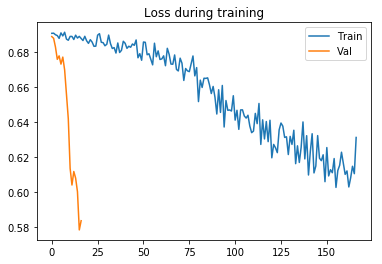

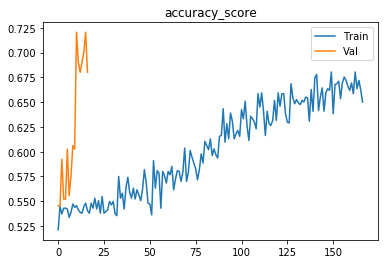

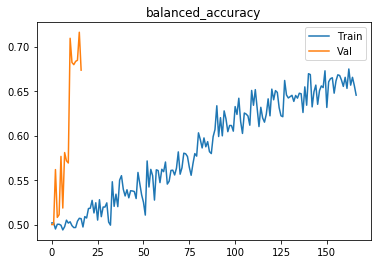

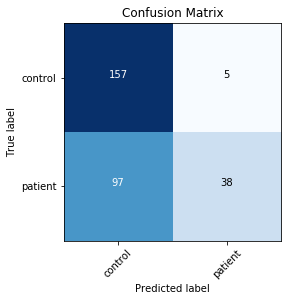

###### Starting inner fold 3
{'model': 'ModelLiu', 'batch_size': 12, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 116001
torch.Size([1, 72, 57, 75])


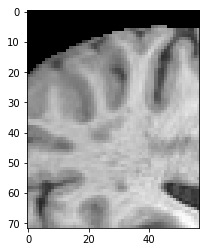

[0,    10] loss: 0.69340
[0,    20] loss: 0.69620
[0,    30] loss: 0.69632
[0,    40] loss: 0.69118
[0,    50] loss: 0.69219
[0,    60] loss: 0.68673
[0,    70] loss: 0.67251
[0,    80] loss: 0.71556
[0,    90] loss: 0.69202
Time elapsed: 0h:1m:47s
train accuracy_score: 53.71 %
train balanced_accuracy: 52.69 %
val accuracy_score: 54.55 %
val balanced_accuracy: 50.00 %
Val loss: 0.689274
[1,    10] loss: 0.69568
[1,    20] loss: 0.67585
[1,    30] loss: 0.69472
[1,    40] loss: 0.67793
[1,    50] loss: 0.69175
[1,    60] loss: 0.69129
[1,    70] loss: 0.67571
[1,    80] loss: 0.68809
[1,    90] loss: 0.70782
Time elapsed: 0h:5m:23s
train accuracy_score: 54.38 %
train balanced_accuracy: 50.18 %
[2,    10] loss: 0.69227
[2,    20] loss: 0.68908
[2,    30] loss: 0.67924
[2,    40] loss: 0.68311
[2,    50] loss: 0.69218
[2,    60] loss: 0.71046
[2,    70] loss: 0.68189
[2,    80] loss: 0.69164
[2,    90] loss: 0.69320
Time elapsed: 0h:7m:13s
train accuracy_score: 54.05 %
train balanced_accu

[25,    20] loss: 0.67783
[25,    30] loss: 0.68598
[25,    40] loss: 0.68664
[25,    50] loss: 0.68388
[25,    60] loss: 0.67455
[25,    70] loss: 0.67362
[25,    80] loss: 0.69218
[25,    90] loss: 0.69213
Time elapsed: 0h:52m:20s
train accuracy_score: 55.31 %
train balanced_accuracy: 52.06 %
[26,    10] loss: 0.67733
[26,    20] loss: 0.67803
[26,    30] loss: 0.70892
[26,    40] loss: 0.68548
[26,    50] loss: 0.67979
[26,    60] loss: 0.67969
[26,    70] loss: 0.67931
[26,    80] loss: 0.68202
[26,    90] loss: 0.67354
Time elapsed: 0h:54m:5s
train accuracy_score: 55.23 %
train balanced_accuracy: 52.08 %
[27,    10] loss: 0.67448
[27,    20] loss: 0.70852
[27,    30] loss: 0.68006
[27,    40] loss: 0.68355
[27,    50] loss: 0.68599
[27,    60] loss: 0.69916
[27,    70] loss: 0.68615
[27,    80] loss: 0.69699
[27,    90] loss: 0.67383
Time elapsed: 0h:55m:55s
train accuracy_score: 52.87 %
train balanced_accuracy: 50.87 %
[28,    10] loss: 0.69573
[28,    20] loss: 0.67509
[28,    3

[50,    20] loss: 0.67328
[50,    30] loss: 0.70608
[50,    40] loss: 0.68630
[50,    50] loss: 0.67594
[50,    60] loss: 0.67578
[50,    70] loss: 0.69219
[50,    80] loss: 0.68138
[50,    90] loss: 0.67254
Time elapsed: 1h:40m:49s
train accuracy_score: 55.82 %
train balanced_accuracy: 53.90 %
val accuracy_score: 59.60 %
val balanced_accuracy: 56.42 %
Val loss: 0.666864
[51,    10] loss: 0.64995
[51,    20] loss: 0.69030
[51,    30] loss: 0.67447
[51,    40] loss: 0.65756
[51,    50] loss: 0.68148
[51,    60] loss: 0.64639
[51,    70] loss: 0.67920
[51,    80] loss: 0.68361
[51,    90] loss: 0.69278
Time elapsed: 1h:44m:23s
train accuracy_score: 56.24 %
train balanced_accuracy: 54.47 %
[52,    10] loss: 0.67906
[52,    20] loss: 0.67964
[52,    30] loss: 0.66694
[52,    40] loss: 0.66180
[52,    50] loss: 0.68940
[52,    60] loss: 0.68827
[52,    70] loss: 0.69253
[52,    80] loss: 0.67714
[52,    90] loss: 0.69602
Time elapsed: 1h:46m:12s
train accuracy_score: 54.72 %
train balanced_

[75,    10] loss: 0.69061
[75,    20] loss: 0.67891
[75,    30] loss: 0.64567
[75,    40] loss: 0.64060
[75,    50] loss: 0.66913
[75,    60] loss: 0.67064
[75,    70] loss: 0.68320
[75,    80] loss: 0.67082
[75,    90] loss: 0.64820
Time elapsed: 2h:30m:47s
train accuracy_score: 60.29 %
train balanced_accuracy: 59.21 %
[76,    10] loss: 0.65167
[76,    20] loss: 0.67171
[76,    30] loss: 0.68391
[76,    40] loss: 0.70180
[76,    50] loss: 0.67269
[76,    60] loss: 0.66305
[76,    70] loss: 0.63497
[76,    80] loss: 0.65222
[76,    90] loss: 0.63170
Time elapsed: 2h:32m:35s
train accuracy_score: 61.38 %
train balanced_accuracy: 60.45 %
[77,    10] loss: 0.68210
[77,    20] loss: 0.64188
[77,    30] loss: 0.63872
[77,    40] loss: 0.68325
[77,    50] loss: 0.66721
[77,    60] loss: 0.66917
[77,    70] loss: 0.65912
[77,    80] loss: 0.62670
[77,    90] loss: 0.72218
Time elapsed: 2h:34m:25s
train accuracy_score: 59.19 %
train balanced_accuracy: 57.81 %
[78,    10] loss: 0.68186
[78,    

[100,    10] loss: 0.65381
[100,    20] loss: 0.61652
[100,    30] loss: 0.62651
[100,    40] loss: 0.65131
[100,    50] loss: 0.65759
[100,    60] loss: 0.60250
[100,    70] loss: 0.66898
[100,    80] loss: 0.61368
[100,    90] loss: 0.66588
Time elapsed: 3h:19m:13s
train accuracy_score: 64.59 %
train balanced_accuracy: 63.81 %
val accuracy_score: 63.30 %
val balanced_accuracy: 61.23 %
Val loss: 0.626590
[101,    10] loss: 0.60891
[101,    20] loss: 0.64784
[101,    30] loss: 0.64908
[101,    40] loss: 0.59320
[101,    50] loss: 0.65648
[101,    60] loss: 0.64684
[101,    70] loss: 0.67731
[101,    80] loss: 0.63732
[101,    90] loss: 0.61803
Time elapsed: 3h:22m:51s
train accuracy_score: 65.18 %
train balanced_accuracy: 64.52 %
[102,    10] loss: 0.65255
[102,    20] loss: 0.65455
[102,    30] loss: 0.60628
[102,    40] loss: 0.59524
[102,    50] loss: 0.66446
[102,    60] loss: 0.66661
[102,    70] loss: 0.69940
[102,    80] loss: 0.65525
[102,    90] loss: 0.60913
Time elapsed: 3h:

[124,    20] loss: 0.63295
[124,    30] loss: 0.62269
[124,    40] loss: 0.62317
[124,    50] loss: 0.66357
[124,    60] loss: 0.66281
[124,    70] loss: 0.59652
[124,    80] loss: 0.59031
[124,    90] loss: 0.60295
Time elapsed: 4h:7m:58s
train accuracy_score: 65.60 %
train balanced_accuracy: 64.89 %
[125,    10] loss: 0.59664
[125,    20] loss: 0.63972
[125,    30] loss: 0.59868
[125,    40] loss: 0.64372
[125,    50] loss: 0.60744
[125,    60] loss: 0.60210
[125,    70] loss: 0.67637
[125,    80] loss: 0.66696
[125,    90] loss: 0.63590
Time elapsed: 4h:9m:44s
train accuracy_score: 64.92 %
train balanced_accuracy: 64.15 %
[126,    10] loss: 0.66343
[126,    20] loss: 0.65122
[126,    30] loss: 0.62796
[126,    40] loss: 0.70909
[126,    50] loss: 0.61132
[126,    60] loss: 0.67770
[126,    70] loss: 0.65515
[126,    80] loss: 0.61264
[126,    90] loss: 0.63936
Time elapsed: 4h:11m:33s
train accuracy_score: 63.24 %
train balanced_accuracy: 62.54 %
[127,    10] loss: 0.65532
[127,    

[148,    60] loss: 0.59203
[148,    70] loss: 0.57720
[148,    80] loss: 0.64630
[148,    90] loss: 0.62204
Time elapsed: 4h:54m:37s
train accuracy_score: 67.62 %
train balanced_accuracy: 67.25 %
[149,    10] loss: 0.65726
[149,    20] loss: 0.66348
[149,    30] loss: 0.62431
[149,    40] loss: 0.60899
[149,    50] loss: 0.66306
[149,    60] loss: 0.62016
[149,    70] loss: 0.63985
[149,    80] loss: 0.58376
[149,    90] loss: 0.60582
Time elapsed: 4h:56m:27s
train accuracy_score: 65.18 %
train balanced_accuracy: 64.47 %
[150,    10] loss: 0.63993
[150,    20] loss: 0.61433
[150,    30] loss: 0.59377
[150,    40] loss: 0.62631
[150,    50] loss: 0.57219
[150,    60] loss: 0.57281
[150,    70] loss: 0.62790
[150,    80] loss: 0.60335
[150,    90] loss: 0.68290
Time elapsed: 4h:58m:16s
train accuracy_score: 66.02 %
train balanced_accuracy: 65.25 %
val accuracy_score: 67.34 %
val balanced_accuracy: 68.09 %
Val loss: 0.604937
[151,    10] loss: 0.62892
[151,    20] loss: 0.63106
[151,    3

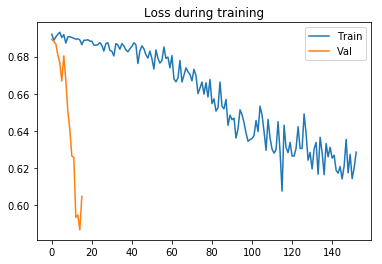

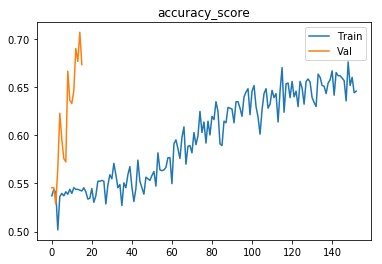

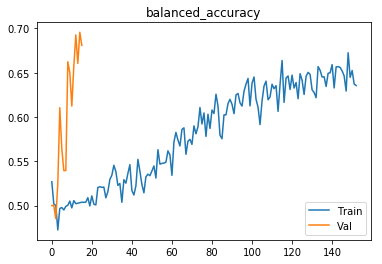

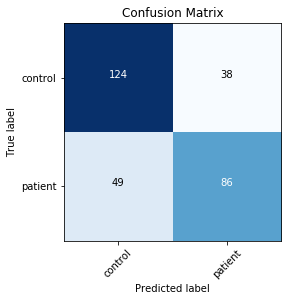

###### Starting inner fold 4
{'model': 'ModelLiu', 'batch_size': 16, 'patience': 16, 'lr': 5e-05}
Trainable model parameters: 116001
torch.Size([1, 72, 57, 75])


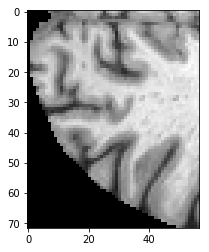

[0,    10] loss: 0.69814
[0,    20] loss: 0.69059
[0,    30] loss: 0.68233
[0,    40] loss: 0.69920
[0,    50] loss: 0.70021
[0,    60] loss: 0.69178
[0,    70] loss: 0.68537
Time elapsed: 0h:1m:52s
train accuracy_score: 51.94 %
train balanced_accuracy: 48.86 %
val accuracy_score: 54.55 %
val balanced_accuracy: 50.00 %
Val loss: 0.688982
[1,    10] loss: 0.70135
[1,    20] loss: 0.68271
[1,    30] loss: 0.69052
[1,    40] loss: 0.67742
[1,    50] loss: 0.70178
[1,    60] loss: 0.68637
[1,    70] loss: 0.69200
Time elapsed: 0h:5m:30s
train accuracy_score: 54.38 %
train balanced_accuracy: 50.18 %
[2,    10] loss: 0.69198
[2,    20] loss: 0.68816
[2,    30] loss: 0.68118
[2,    40] loss: 0.69408
[2,    50] loss: 0.68808
[2,    60] loss: 0.69191
[2,    70] loss: 0.68753
Time elapsed: 0h:7m:17s
train accuracy_score: 54.72 %
train balanced_accuracy: 50.58 %
[3,    10] loss: 0.68113
[3,    20] loss: 0.71901
[3,    30] loss: 0.69055
[3,    40] loss: 0.68211
[3,    50] loss: 0.68811
[3,    60] 

[30,    10] loss: 0.68241
[30,    20] loss: 0.66725
[30,    30] loss: 0.69018
[30,    40] loss: 0.68687
[30,    50] loss: 0.69491
[30,    60] loss: 0.67609
[30,    70] loss: 0.68461
Time elapsed: 1h:2m:0s
train accuracy_score: 54.38 %
train balanced_accuracy: 52.12 %
val accuracy_score: 54.55 %
val balanced_accuracy: 50.80 %
Val loss: 0.670694
[31,    10] loss: 0.68516
[31,    20] loss: 0.68292
[31,    30] loss: 0.67823
[31,    40] loss: 0.68193
[31,    50] loss: 0.68235
[31,    60] loss: 0.67419
[31,    70] loss: 0.68981
Time elapsed: 1h:5m:38s
train accuracy_score: 55.23 %
train balanced_accuracy: 52.62 %
[32,    10] loss: 0.66151
[32,    20] loss: 0.67817
[32,    30] loss: 0.69761
[32,    40] loss: 0.67006
[32,    50] loss: 0.68062
[32,    60] loss: 0.66785
[32,    70] loss: 0.66911
Time elapsed: 1h:7m:27s
train accuracy_score: 56.75 %
train balanced_accuracy: 54.65 %
[33,    10] loss: 0.65643
[33,    20] loss: 0.67017
[33,    30] loss: 0.67387
[33,    40] loss: 0.67874
[33,    50] 

[59,    70] loss: 0.68106
Time elapsed: 2h:0m:8s
train accuracy_score: 59.95 %
train balanced_accuracy: 58.65 %
[60,    10] loss: 0.67834
[60,    20] loss: 0.67501
[60,    30] loss: 0.63073
[60,    40] loss: 0.64305
[60,    50] loss: 0.65689
[60,    60] loss: 0.63476
[60,    70] loss: 0.64028
Time elapsed: 2h:1m:55s
train accuracy_score: 61.64 %
train balanced_accuracy: 60.32 %
val accuracy_score: 66.67 %
val balanced_accuracy: 64.51 %
Val loss: 0.624987
[61,    10] loss: 0.65345
[61,    20] loss: 0.66579
[61,    30] loss: 0.66753
[61,    40] loss: 0.62570
[61,    50] loss: 0.62863
[61,    60] loss: 0.65119
[61,    70] loss: 0.64688
Time elapsed: 2h:5m:30s
train accuracy_score: 62.90 %
train balanced_accuracy: 61.95 %
[62,    10] loss: 0.67126
[62,    20] loss: 0.64644
[62,    30] loss: 0.63309
[62,    40] loss: 0.66095
[62,    50] loss: 0.62402
[62,    60] loss: 0.64846
[62,    70] loss: 0.65149
Time elapsed: 2h:7m:14s
train accuracy_score: 63.15 %
train balanced_accuracy: 62.17 %
[63

[89,    20] loss: 0.65296
[89,    30] loss: 0.62796
[89,    40] loss: 0.62848
[89,    50] loss: 0.65971
[89,    60] loss: 0.64281
[89,    70] loss: 0.65246
Time elapsed: 3h:0m:43s
train accuracy_score: 62.31 %
train balanced_accuracy: 61.72 %
[90,    10] loss: 0.60406
[90,    20] loss: 0.69336
[90,    30] loss: 0.60623
[90,    40] loss: 0.62174
[90,    50] loss: 0.61854
[90,    60] loss: 0.60908
[90,    70] loss: 0.64436
Time elapsed: 3h:2m:36s
train accuracy_score: 63.58 %
train balanced_accuracy: 62.78 %
val accuracy_score: 69.02 %
val balanced_accuracy: 67.96 %
Val loss: 0.599443
[91,    10] loss: 0.61624
[91,    20] loss: 0.59984
[91,    30] loss: 0.64833
[91,    40] loss: 0.64449
[91,    50] loss: 0.63619
[91,    60] loss: 0.62775
[91,    70] loss: 0.57681
Time elapsed: 3h:6m:17s
train accuracy_score: 65.18 %
train balanced_accuracy: 64.49 %
[92,    10] loss: 0.64572
[92,    20] loss: 0.63387
[92,    30] loss: 0.62615
[92,    40] loss: 0.63838
[92,    50] loss: 0.60649
[92,    60]

[118,    30] loss: 0.60893
[118,    40] loss: 0.59524
[118,    50] loss: 0.62729
[118,    60] loss: 0.62397
[118,    70] loss: 0.64890
Time elapsed: 4h:1m:24s
train accuracy_score: 65.51 %
train balanced_accuracy: 64.62 %
[119,    10] loss: 0.60610
[119,    20] loss: 0.59768
[119,    30] loss: 0.63014
[119,    40] loss: 0.61494
[119,    50] loss: 0.58805
[119,    60] loss: 0.63176
[119,    70] loss: 0.61924
Time elapsed: 4h:3m:15s
train accuracy_score: 66.61 %
train balanced_accuracy: 66.00 %
[120,    10] loss: 0.62956
[120,    20] loss: 0.58651
[120,    30] loss: 0.63915
[120,    40] loss: 0.63622
[120,    50] loss: 0.60504
[120,    60] loss: 0.56699
[120,    70] loss: 0.63257
Time elapsed: 4h:5m:6s
train accuracy_score: 66.95 %
train balanced_accuracy: 66.29 %
val accuracy_score: 69.02 %
val balanced_accuracy: 68.21 %
Val loss: 0.587899
[121,    10] loss: 0.59399
[121,    20] loss: 0.62575
[121,    30] loss: 0.60376
[121,    40] loss: 0.62888
[121,    50] loss: 0.63720
[121,    60] l

[147,    10] loss: 0.62179
[147,    20] loss: 0.58707
[147,    30] loss: 0.58053
[147,    40] loss: 0.58904
[147,    50] loss: 0.59175
[147,    60] loss: 0.62925
[147,    70] loss: 0.60902
Time elapsed: 5h:1m:34s
train accuracy_score: 68.80 %
train balanced_accuracy: 68.50 %
[148,    10] loss: 0.59766
[148,    20] loss: 0.57662
[148,    30] loss: 0.62642
[148,    40] loss: 0.63445
[148,    50] loss: 0.61986
[148,    60] loss: 0.61566
[148,    70] loss: 0.63999
Time elapsed: 5h:3m:32s
train accuracy_score: 66.95 %
train balanced_accuracy: 66.26 %
[149,    10] loss: 0.66076
[149,    20] loss: 0.58962
[149,    30] loss: 0.58484
[149,    40] loss: 0.58788
[149,    50] loss: 0.60472
[149,    60] loss: 0.56396
[149,    70] loss: 0.54604
Time elapsed: 5h:5m:26s
train accuracy_score: 68.72 %
train balanced_accuracy: 68.07 %
[150,    10] loss: 0.63353
[150,    20] loss: 0.61270
[150,    30] loss: 0.59648
[150,    40] loss: 0.62356
[150,    50] loss: 0.55089
[150,    60] loss: 0.58414
[150,    7

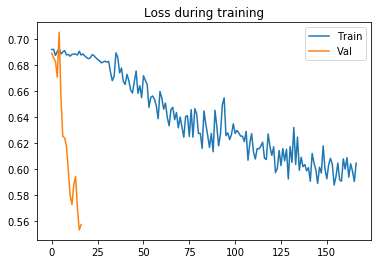

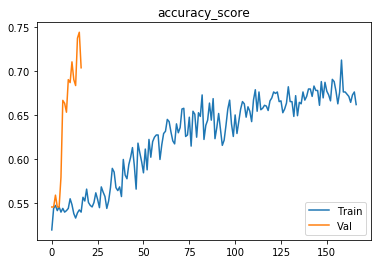

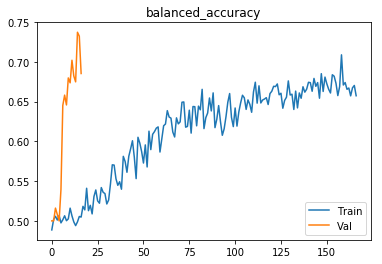

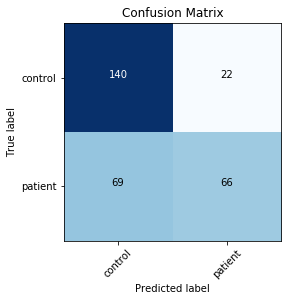

Finished outer fold.
{'final_acc': 0.68703703703703711, 'best_acc': 0.75864197530864197, 'final_iter': 15, 'best_iter': 11, 'params': {'model': 'ModelLiu', 'batch_size': 32, 'patience': 12, 'lr': 0.0001}, 'inner_fold_idx': 1}
###### Starting outer fold 1
1186
297
Shuffled the data..
###### Starting inner fold 0
{'model': 'ModelLiu', 'batch_size': 32, 'patience': 12, 'lr': 0.0001}
Trainable model parameters: 116001
torch.Size([1, 72, 57, 75])


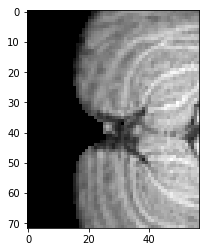

[0,    10] loss: 0.69959
[0,    20] loss: 0.69345
[0,    30] loss: 0.69350
Time elapsed: 0h:1m:58s
train accuracy_score: 50.76 %
train balanced_accuracy: 48.63 %
val accuracy_score: 55.56 %
val balanced_accuracy: 50.00 %
Val loss: 0.687611
[1,    10] loss: 0.69244
[1,    20] loss: 0.69936
[1,    30] loss: 0.68944
Time elapsed: 0h:5m:48s
train accuracy_score: 52.19 %
train balanced_accuracy: 49.85 %
[2,    10] loss: 0.68671
[2,    20] loss: 0.69600
[2,    30] loss: 0.69696
Time elapsed: 0h:7m:48s
train accuracy_score: 52.53 %
train balanced_accuracy: 50.09 %
[3,    10] loss: 0.69219
[3,    20] loss: 0.69211
[3,    30] loss: 0.69431
Time elapsed: 0h:9m:44s
train accuracy_score: 51.60 %
train balanced_accuracy: 49.57 %
[4,    10] loss: 0.69450
[4,    20] loss: 0.69169
[4,    30] loss: 0.69166
Time elapsed: 0h:11m:43s
train accuracy_score: 51.77 %
train balanced_accuracy: 50.64 %
[5,    10] loss: 0.69354
[5,    20] loss: 0.68807
[5,    30] loss: 0.69239
Time elapsed: 0h:13m:42s
train accur

[47,    30] loss: 0.67082
Time elapsed: 1h:40m:21s
train accuracy_score: 58.77 %
train balanced_accuracy: 57.94 %
[48,    10] loss: 0.66262
[48,    20] loss: 0.67984
[48,    30] loss: 0.67298
Time elapsed: 1h:42m:12s
train accuracy_score: 57.84 %
train balanced_accuracy: 56.91 %
[49,    10] loss: 0.67265
[49,    20] loss: 0.66672
[49,    30] loss: 0.66350
Time elapsed: 1h:44m:5s
train accuracy_score: 58.94 %
train balanced_accuracy: 58.54 %
[50,    10] loss: 0.67722
[50,    20] loss: 0.66661
[50,    30] loss: 0.66511
Time elapsed: 1h:46m:6s
train accuracy_score: 59.70 %
train balanced_accuracy: 59.05 %
val accuracy_score: 61.28 %
val balanced_accuracy: 58.26 %
Val loss: 0.656201
[51,    10] loss: 0.67622
[51,    20] loss: 0.67182
[51,    30] loss: 0.66670
Time elapsed: 1h:49m:50s
train accuracy_score: 59.19 %
train balanced_accuracy: 58.51 %
[52,    10] loss: 0.67039
[52,    20] loss: 0.67501
[52,    30] loss: 0.66319
Time elapsed: 1h:51m:42s
train accuracy_score: 59.53 %
train balance

Time elapsed: 3h:17m:50s
train accuracy_score: 61.38 %
train balanced_accuracy: 61.43 %
[95,    10] loss: 0.62149
[95,    20] loss: 0.61048
[95,    30] loss: 0.62704
Time elapsed: 3h:19m:53s
train accuracy_score: 65.94 %
train balanced_accuracy: 65.86 %
[96,    10] loss: 0.62147
[96,    20] loss: 0.61202
[96,    30] loss: 0.63079
Time elapsed: 3h:21m:46s
train accuracy_score: 66.69 %
train balanced_accuracy: 66.64 %
[97,    10] loss: 0.61434
[97,    20] loss: 0.60552
[97,    30] loss: 0.62768
Time elapsed: 3h:23m:38s
train accuracy_score: 65.35 %
train balanced_accuracy: 65.07 %
[98,    10] loss: 0.61989
[98,    20] loss: 0.61537
[98,    30] loss: 0.64816
Time elapsed: 3h:25m:27s
train accuracy_score: 63.58 %
train balanced_accuracy: 63.48 %
[99,    10] loss: 0.62421
[99,    20] loss: 0.66128
[99,    30] loss: 0.62290
Time elapsed: 3h:27m:27s
train accuracy_score: 63.58 %
train balanced_accuracy: 63.31 %
[100,    10] loss: 0.63971
[100,    20] loss: 0.63827
[100,    30] loss: 0.63942
T

[141,    10] loss: 0.67973
[141,    20] loss: 0.58821
[141,    30] loss: 0.62271
Time elapsed: 4h:57m:19s
train accuracy_score: 64.00 %
train balanced_accuracy: 63.48 %
[142,    10] loss: 0.61840
[142,    20] loss: 0.58212
[142,    30] loss: 0.63254
Time elapsed: 4h:59m:11s
train accuracy_score: 67.28 %
train balanced_accuracy: 67.07 %
Early stopping in epoch 143
Total time elapsed: 4h:59m:11s
Writing model to disk...
Best result during training: 0.68. Saving model..
15
[0.5, 0.5553030303030303, 0.52348484848484844, 0.5757575757575758, 0.60757575757575755, 0.58257575757575752, 0.62803030303030305, 0.62348484848484853, 0.57651515151515154, 0.61590909090909096, 0.66818181818181821, 0.66363636363636358, 0.68636363636363629, 0.68257575757575761, 0.6333333333333333]
Finished inner fold.


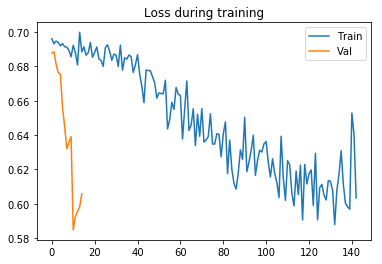

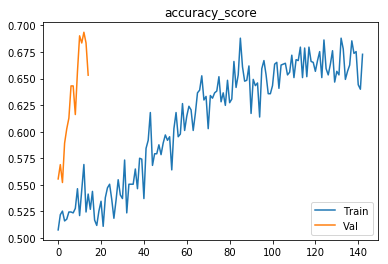

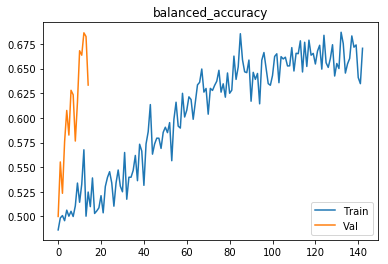

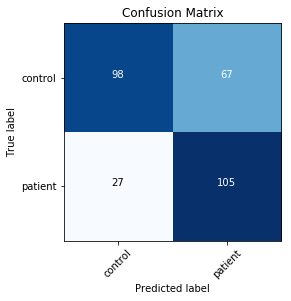

###### Starting inner fold 1
{'model': 'ModelLiu', 'batch_size': 16, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 116001
torch.Size([1, 72, 57, 75])


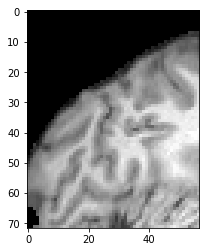

[0,    10] loss: 0.69877
[0,    20] loss: 0.69485
[0,    30] loss: 0.69930
[0,    40] loss: 0.68389
[0,    50] loss: 0.69865
[0,    60] loss: 0.69115
[0,    70] loss: 0.68989
Time elapsed: 0h:1m:56s
train accuracy_score: 51.52 %
train balanced_accuracy: 50.38 %
val accuracy_score: 55.56 %
val balanced_accuracy: 50.00 %
Val loss: 0.687674
[1,    10] loss: 0.69065
[1,    20] loss: 0.68702
[1,    30] loss: 0.69514
[1,    40] loss: 0.69166
[1,    50] loss: 0.69099
[1,    60] loss: 0.69969
[1,    70] loss: 0.69587
Time elapsed: 0h:5m:38s
train accuracy_score: 52.36 %
train balanced_accuracy: 50.00 %
[2,    10] loss: 0.69405
[2,    20] loss: 0.69029
[2,    30] loss: 0.69494
[2,    40] loss: 0.69671
[2,    50] loss: 0.69341
[2,    60] loss: 0.69270
[2,    70] loss: 0.69070
Time elapsed: 0h:7m:29s
train accuracy_score: 51.77 %
train balanced_accuracy: 50.15 %
[3,    10] loss: 0.69398
[3,    20] loss: 0.69109
[3,    30] loss: 0.70229
[3,    40] loss: 0.69065
[3,    50] loss: 0.69828
[3,    60] 

[30,    10] loss: 0.69543
[30,    20] loss: 0.69094
[30,    30] loss: 0.68946
[30,    40] loss: 0.67631
[30,    50] loss: 0.66368
[30,    60] loss: 0.71095
[30,    70] loss: 0.67749
Time elapsed: 1h:2m:44s
train accuracy_score: 55.23 %
train balanced_accuracy: 53.91 %
val accuracy_score: 57.24 %
val balanced_accuracy: 57.80 %
Val loss: 0.687376
[31,    10] loss: 0.68728
[31,    20] loss: 0.69808
[31,    30] loss: 0.68740
[31,    40] loss: 0.68989
[31,    50] loss: 0.68713
[31,    60] loss: 0.68794
[31,    70] loss: 0.68970
Time elapsed: 1h:6m:25s
train accuracy_score: 52.95 %
train balanced_accuracy: 52.89 %
[32,    10] loss: 0.69345
[32,    20] loss: 0.71640
[32,    30] loss: 0.68645
[32,    40] loss: 0.69581
[32,    50] loss: 0.67457
[32,    60] loss: 0.69110
[32,    70] loss: 0.68141
Time elapsed: 1h:8m:14s
train accuracy_score: 52.78 %
train balanced_accuracy: 51.38 %
[33,    10] loss: 0.69049
[33,    20] loss: 0.67656
[33,    30] loss: 0.67780
[33,    40] loss: 0.71283
[33,    50]

[59,    70] loss: 0.67876
Time elapsed: 2h:1m:55s
train accuracy_score: 54.47 %
train balanced_accuracy: 53.76 %
[60,    10] loss: 0.68484
[60,    20] loss: 0.67949
[60,    30] loss: 0.68549
[60,    40] loss: 0.65621
[60,    50] loss: 0.69850
[60,    60] loss: 0.67742
[60,    70] loss: 0.67212
Time elapsed: 2h:3m:46s
train accuracy_score: 56.24 %
train balanced_accuracy: 55.35 %
val accuracy_score: 58.59 %
val balanced_accuracy: 58.33 %
Val loss: 0.674424
[61,    10] loss: 0.67808
[61,    20] loss: 0.66805
[61,    30] loss: 0.69418
[61,    40] loss: 0.66129
[61,    50] loss: 0.66789
[61,    60] loss: 0.69386
[61,    70] loss: 0.67537
Time elapsed: 2h:7m:30s
train accuracy_score: 58.35 %
train balanced_accuracy: 57.82 %
[62,    10] loss: 0.69919
[62,    20] loss: 0.67423
[62,    30] loss: 0.65881
[62,    40] loss: 0.66975
[62,    50] loss: 0.67188
[62,    60] loss: 0.68682
[62,    70] loss: 0.68064
Time elapsed: 2h:9m:22s
train accuracy_score: 56.24 %
train balanced_accuracy: 55.64 %
[6

[89,    20] loss: 0.66906
[89,    30] loss: 0.63653
[89,    40] loss: 0.66696
[89,    50] loss: 0.67373
[89,    60] loss: 0.68521
[89,    70] loss: 0.64145
Time elapsed: 3h:2m:7s
train accuracy_score: 58.52 %
train balanced_accuracy: 58.01 %
[90,    10] loss: 0.66364
[90,    20] loss: 0.67033
[90,    30] loss: 0.65489
[90,    40] loss: 0.62927
[90,    50] loss: 0.65919
[90,    60] loss: 0.65151
[90,    70] loss: 0.68203
Time elapsed: 3h:3m:54s
train accuracy_score: 60.96 %
train balanced_accuracy: 60.66 %
val accuracy_score: 59.26 %
val balanced_accuracy: 55.15 %
Val loss: 0.653779
[91,    10] loss: 0.66709
[91,    20] loss: 0.64864
[91,    30] loss: 0.72897
[91,    40] loss: 0.67484
[91,    50] loss: 0.67141
[91,    60] loss: 0.62940
[91,    70] loss: 0.67852
Time elapsed: 3h:7m:27s
train accuracy_score: 59.02 %
train balanced_accuracy: 58.71 %
[92,    10] loss: 0.63492
[92,    20] loss: 0.63765
[92,    30] loss: 0.61138
[92,    40] loss: 0.60669
[92,    50] loss: 0.67579
[92,    60] 

[118,    30] loss: 0.63159
[118,    40] loss: 0.65854
[118,    50] loss: 0.67140
[118,    60] loss: 0.67332
[118,    70] loss: 0.64088
Time elapsed: 4h:0m:17s
train accuracy_score: 63.32 %
train balanced_accuracy: 62.92 %
[119,    10] loss: 0.63226
[119,    20] loss: 0.64192
[119,    30] loss: 0.62229
[119,    40] loss: 0.63569
[119,    50] loss: 0.64176
[119,    60] loss: 0.64427
[119,    70] loss: 0.61971
Time elapsed: 4h:2m:8s
train accuracy_score: 64.00 %
train balanced_accuracy: 63.67 %
[120,    10] loss: 0.59986
[120,    20] loss: 0.66571
[120,    30] loss: 0.63498
[120,    40] loss: 0.61499
[120,    50] loss: 0.64213
[120,    60] loss: 0.65207
[120,    70] loss: 0.63412
Time elapsed: 4h:3m:58s
train accuracy_score: 63.41 %
train balanced_accuracy: 63.15 %
val accuracy_score: 71.72 %
val balanced_accuracy: 71.21 %
Val loss: 0.602752
[121,    10] loss: 0.62858
[121,    20] loss: 0.62817
[121,    30] loss: 0.62670
[121,    40] loss: 0.63806
[121,    50] loss: 0.63899
[121,    60] l

[147,    10] loss: 0.65083
[147,    20] loss: 0.61033
[147,    30] loss: 0.58668
[147,    40] loss: 0.56816
[147,    50] loss: 0.61263
[147,    60] loss: 0.62395
[147,    70] loss: 0.60505
Time elapsed: 4h:59m:5s
train accuracy_score: 66.86 %
train balanced_accuracy: 66.76 %
[148,    10] loss: 0.62503
[148,    20] loss: 0.62490
[148,    30] loss: 0.60421
[148,    40] loss: 0.57749
[148,    50] loss: 0.59697
[148,    60] loss: 0.64829
[148,    70] loss: 0.59036
Time elapsed: 5h:0m:56s
train accuracy_score: 66.10 %
train balanced_accuracy: 65.99 %
[149,    10] loss: 0.58545
[149,    20] loss: 0.64814
[149,    30] loss: 0.59649
[149,    40] loss: 0.64503
[149,    50] loss: 0.66703
[149,    60] loss: 0.65181
[149,    70] loss: 0.56134
Time elapsed: 5h:2m:47s
train accuracy_score: 64.92 %
train balanced_accuracy: 64.77 %
[150,    10] loss: 0.58528
[150,    20] loss: 0.64461
[150,    30] loss: 0.59949
[150,    40] loss: 0.64713
[150,    50] loss: 0.63316
[150,    60] loss: 0.60510
[150,    7

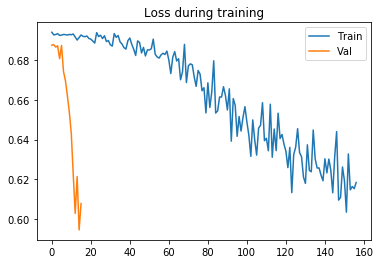

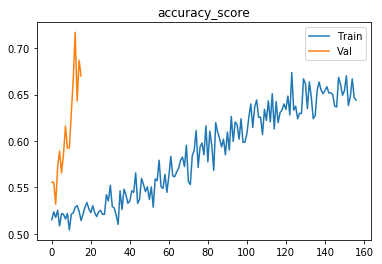

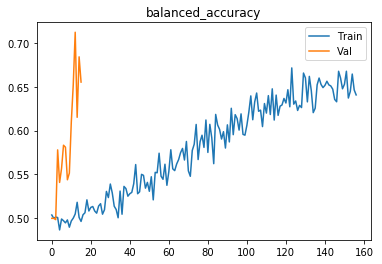

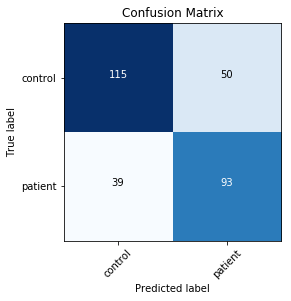

###### Starting inner fold 2
{'model': 'ModelLiu', 'batch_size': 16, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 116001
torch.Size([1, 72, 57, 75])


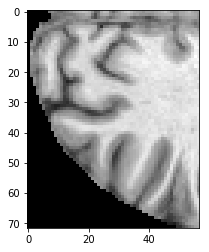

[0,    10] loss: 0.69036
[0,    20] loss: 0.69068
[0,    30] loss: 0.70090
[0,    40] loss: 0.68695
[0,    50] loss: 0.69572
[0,    60] loss: 0.69547
[0,    70] loss: 0.69459
Time elapsed: 0h:1m:50s
train accuracy_score: 52.11 %
train balanced_accuracy: 49.73 %
val accuracy_score: 55.56 %
val balanced_accuracy: 50.00 %
Val loss: 0.689360
[1,    10] loss: 0.69088
[1,    20] loss: 0.69435
[1,    30] loss: 0.69015
[1,    40] loss: 0.70178
[1,    50] loss: 0.68922
[1,    60] loss: 0.68396
[1,    70] loss: 0.69947
Time elapsed: 0h:5m:29s
train accuracy_score: 52.45 %
train balanced_accuracy: 50.02 %
[2,    10] loss: 0.68489
[2,    20] loss: 0.69327
[2,    30] loss: 0.68954
[2,    40] loss: 0.68845
[2,    50] loss: 0.69952
[2,    60] loss: 0.69274
[2,    70] loss: 0.69611
Time elapsed: 0h:7m:21s
train accuracy_score: 52.53 %
train balanced_accuracy: 50.09 %
[3,    10] loss: 0.68984
[3,    20] loss: 0.69081
[3,    30] loss: 0.69016
[3,    40] loss: 0.69590
[3,    50] loss: 0.69237
[3,    60] 

[30,    10] loss: 0.67968
[30,    20] loss: 0.69860
[30,    30] loss: 0.67011
[30,    40] loss: 0.68251
[30,    50] loss: 0.67203
[30,    60] loss: 0.67492
[30,    70] loss: 0.68011
Time elapsed: 1h:2m:29s
train accuracy_score: 55.40 %
train balanced_accuracy: 55.01 %
val accuracy_score: 59.26 %
val balanced_accuracy: 58.33 %
Val loss: 0.670268
[31,    10] loss: 0.67947
[31,    20] loss: 0.66642
[31,    30] loss: 0.67497
[31,    40] loss: 0.68053
[31,    50] loss: 0.68044
[31,    60] loss: 0.68374
[31,    70] loss: 0.68861
Time elapsed: 1h:6m:9s
train accuracy_score: 57.00 %
train balanced_accuracy: 56.42 %
[32,    10] loss: 0.66656
[32,    20] loss: 0.66741
[32,    30] loss: 0.69247
[32,    40] loss: 0.66543
[32,    50] loss: 0.68546
[32,    60] loss: 0.67245
[32,    70] loss: 0.66967
Time elapsed: 1h:8m:1s
train accuracy_score: 57.76 %
train balanced_accuracy: 57.25 %
[33,    10] loss: 0.70260
[33,    20] loss: 0.66656
[33,    30] loss: 0.67995
[33,    40] loss: 0.68332
[33,    50] l

[59,    70] loss: 0.63484
Time elapsed: 2h:0m:30s
train accuracy_score: 61.72 %
train balanced_accuracy: 61.59 %
[60,    10] loss: 0.65745
[60,    20] loss: 0.65708
[60,    30] loss: 0.63739
[60,    40] loss: 0.63416
[60,    50] loss: 0.66505
[60,    60] loss: 0.64956
[60,    70] loss: 0.66755
Time elapsed: 2h:2m:20s
train accuracy_score: 61.72 %
train balanced_accuracy: 61.50 %
val accuracy_score: 62.63 %
val balanced_accuracy: 60.30 %
Val loss: 0.638530
[61,    10] loss: 0.64530
[61,    20] loss: 0.69765
[61,    30] loss: 0.64949
[61,    40] loss: 0.65653
[61,    50] loss: 0.65026
[61,    60] loss: 0.67874
[61,    70] loss: 0.64268
Time elapsed: 2h:5m:59s
train accuracy_score: 60.29 %
train balanced_accuracy: 59.81 %
[62,    10] loss: 0.64383
[62,    20] loss: 0.65362
[62,    30] loss: 0.65334
[62,    40] loss: 0.66437
[62,    50] loss: 0.65052
[62,    60] loss: 0.63779
[62,    70] loss: 0.65163
Time elapsed: 2h:7m:50s
train accuracy_score: 61.97 %
train balanced_accuracy: 61.54 %
[6

[89,    20] loss: 0.63181
[89,    30] loss: 0.57405
[89,    40] loss: 0.64307
[89,    50] loss: 0.62655
[89,    60] loss: 0.66603
[89,    70] loss: 0.62046
Time elapsed: 3h:1m:10s
train accuracy_score: 64.76 %
train balanced_accuracy: 64.39 %
[90,    10] loss: 0.59823
[90,    20] loss: 0.63202
[90,    30] loss: 0.65587
[90,    40] loss: 0.65541
[90,    50] loss: 0.62627
[90,    60] loss: 0.60895
[90,    70] loss: 0.66481
Time elapsed: 3h:3m:1s
train accuracy_score: 63.41 %
train balanced_accuracy: 63.10 %
val accuracy_score: 63.97 %
val balanced_accuracy: 64.47 %
Val loss: 0.617271
[91,    10] loss: 0.63209
[91,    20] loss: 0.62552
[91,    30] loss: 0.64883
[91,    40] loss: 0.64064
[91,    50] loss: 0.63353
[91,    60] loss: 0.65394
[91,    70] loss: 0.66774
Time elapsed: 3h:6m:42s
train accuracy_score: 62.90 %
train balanced_accuracy: 62.65 %
[92,    10] loss: 0.63252
[92,    20] loss: 0.65024
[92,    30] loss: 0.62238
[92,    40] loss: 0.60961
[92,    50] loss: 0.60438
[92,    60] 

[118,    30] loss: 0.61111
[118,    40] loss: 0.60615
[118,    50] loss: 0.60295
[118,    60] loss: 0.58993
[118,    70] loss: 0.60759
Time elapsed: 4h:0m:11s
train accuracy_score: 65.60 %
train balanced_accuracy: 65.48 %
[119,    10] loss: 0.59940
[119,    20] loss: 0.62536
[119,    30] loss: 0.64450
[119,    40] loss: 0.60002
[119,    50] loss: 0.60613
[119,    60] loss: 0.61523
[119,    70] loss: 0.59955
Time elapsed: 4h:2m:2s
train accuracy_score: 66.78 %
train balanced_accuracy: 66.58 %
[120,    10] loss: 0.64352
[120,    20] loss: 0.63591
[120,    30] loss: 0.64546
[120,    40] loss: 0.64107
[120,    50] loss: 0.60704
[120,    60] loss: 0.60813
[120,    70] loss: 0.61524
Time elapsed: 4h:3m:55s
train accuracy_score: 65.60 %
train balanced_accuracy: 65.42 %
val accuracy_score: 63.30 %
val balanced_accuracy: 64.32 %
Val loss: 0.629894
[121,    10] loss: 0.64246
[121,    20] loss: 0.58271
[121,    30] loss: 0.60322
[121,    40] loss: 0.65044
[121,    50] loss: 0.61426
[121,    60] l

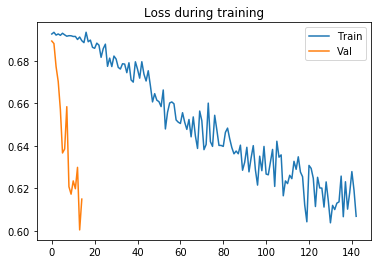

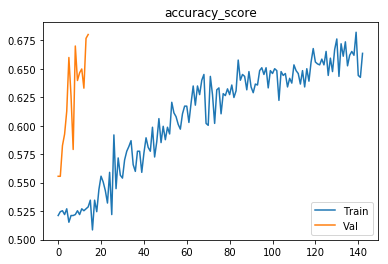

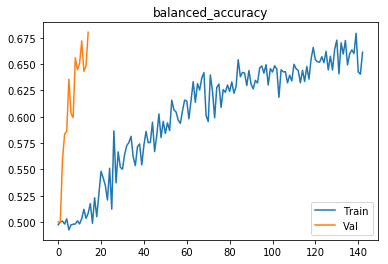

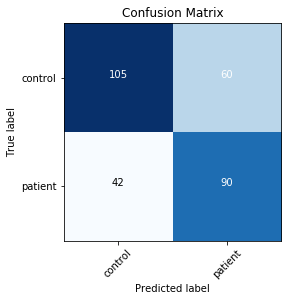

###### Starting inner fold 3
{'model': 'ModelLiu', 'batch_size': 32, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 116001
torch.Size([1, 72, 57, 75])


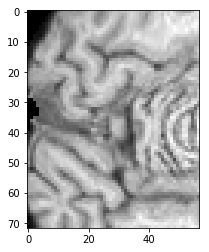

[0,    10] loss: 0.69478
[0,    20] loss: 0.69113
[0,    30] loss: 0.68947
Time elapsed: 0h:1m:56s
train accuracy_score: 52.53 %
train balanced_accuracy: 50.11 %
val accuracy_score: 55.56 %
val balanced_accuracy: 50.00 %
Val loss: 0.688382
[1,    10] loss: 0.69488
[1,    20] loss: 0.69185
[1,    30] loss: 0.69535
Time elapsed: 0h:5m:41s
train accuracy_score: 51.94 %
train balanced_accuracy: 49.53 %
[2,    10] loss: 0.68966
[2,    20] loss: 0.69118
[2,    30] loss: 0.69228
Time elapsed: 0h:7m:37s
train accuracy_score: 52.45 %
train balanced_accuracy: 50.00 %
[3,    10] loss: 0.69597
[3,    20] loss: 0.69272
[3,    30] loss: 0.69061
Time elapsed: 0h:9m:34s
train accuracy_score: 52.45 %
train balanced_accuracy: 50.06 %
[4,    10] loss: 0.69119
[4,    20] loss: 0.68814
[4,    30] loss: 0.69677
Time elapsed: 0h:11m:28s
train accuracy_score: 52.45 %
train balanced_accuracy: 50.00 %
[5,    10] loss: 0.69222
[5,    20] loss: 0.69487
[5,    30] loss: 0.69067
Time elapsed: 0h:13m:23s
train accur

[47,    30] loss: 0.69068
Time elapsed: 1h:41m:21s
train accuracy_score: 54.05 %
train balanced_accuracy: 52.93 %
[48,    10] loss: 0.69165
[48,    20] loss: 0.69690
[48,    30] loss: 0.69057
Time elapsed: 1h:43m:15s
train accuracy_score: 53.46 %
train balanced_accuracy: 53.15 %
[49,    10] loss: 0.68612
[49,    20] loss: 0.67742
[49,    30] loss: 0.68375
Time elapsed: 1h:45m:10s
train accuracy_score: 57.08 %
train balanced_accuracy: 56.46 %
[50,    10] loss: 0.67541
[50,    20] loss: 0.68041
[50,    30] loss: 0.69401
Time elapsed: 1h:47m:6s
train accuracy_score: 54.64 %
train balanced_accuracy: 53.36 %
val accuracy_score: 56.57 %
val balanced_accuracy: 56.67 %
Val loss: 0.681011
[51,    10] loss: 0.68268
[51,    20] loss: 0.68400
[51,    30] loss: 0.69154
Time elapsed: 1h:50m:51s
train accuracy_score: 55.06 %
train balanced_accuracy: 54.42 %
[52,    10] loss: 0.67335
[52,    20] loss: 0.69098
[52,    30] loss: 0.69431
Time elapsed: 1h:52m:47s
train accuracy_score: 54.22 %
train balanc

Time elapsed: 3h:21m:2s
train accuracy_score: 63.07 %
train balanced_accuracy: 62.83 %
[95,    10] loss: 0.65620
[95,    20] loss: 0.65480
[95,    30] loss: 0.65723
Time elapsed: 3h:22m:59s
train accuracy_score: 60.20 %
train balanced_accuracy: 59.88 %
[96,    10] loss: 0.66315
[96,    20] loss: 0.65909
[96,    30] loss: 0.64693
Time elapsed: 3h:24m:55s
train accuracy_score: 60.20 %
train balanced_accuracy: 59.89 %
[97,    10] loss: 0.65380
[97,    20] loss: 0.65685
[97,    30] loss: 0.66528
Time elapsed: 3h:26m:50s
train accuracy_score: 60.54 %
train balanced_accuracy: 60.25 %
[98,    10] loss: 0.66476
[98,    20] loss: 0.67063
[98,    30] loss: 0.64769
Time elapsed: 3h:28m:47s
train accuracy_score: 61.21 %
train balanced_accuracy: 60.76 %
[99,    10] loss: 0.64819
[99,    20] loss: 0.64746
[99,    30] loss: 0.67166
Time elapsed: 3h:30m:46s
train accuracy_score: 59.87 %
train balanced_accuracy: 59.22 %
[100,    10] loss: 0.68424
[100,    20] loss: 0.65619
[100,    30] loss: 0.66123
Ti

[141,    10] loss: 0.62427
[141,    20] loss: 0.62993
[141,    30] loss: 0.63429
Time elapsed: 5h:2m:2s
train accuracy_score: 63.15 %
train balanced_accuracy: 62.99 %
[142,    10] loss: 0.62064
[142,    20] loss: 0.66295
[142,    30] loss: 0.62307
Time elapsed: 5h:4m:4s
train accuracy_score: 63.32 %
train balanced_accuracy: 62.86 %
[143,    10] loss: 0.65673
[143,    20] loss: 0.61524
[143,    30] loss: 0.59488
Time elapsed: 5h:6m:9s
train accuracy_score: 64.00 %
train balanced_accuracy: 63.69 %
[144,    10] loss: 0.64562
[144,    20] loss: 0.62932
[144,    30] loss: 0.62654
Time elapsed: 5h:8m:14s
train accuracy_score: 63.41 %
train balanced_accuracy: 63.22 %
[145,    10] loss: 0.60705
[145,    20] loss: 0.63717
[145,    30] loss: 0.63353
Time elapsed: 5h:10m:16s
train accuracy_score: 63.07 %
train balanced_accuracy: 62.72 %
[146,    10] loss: 0.59849
[146,    20] loss: 0.63604
[146,    30] loss: 0.64287
Time elapsed: 5h:12m:23s
train accuracy_score: 64.67 %
train balanced_accuracy: 6

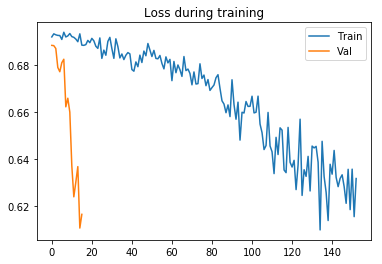

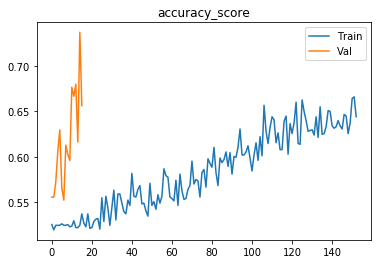

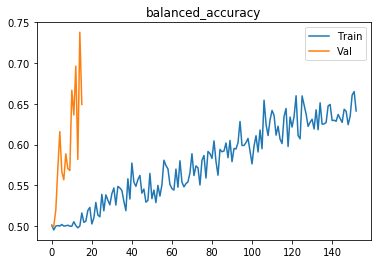

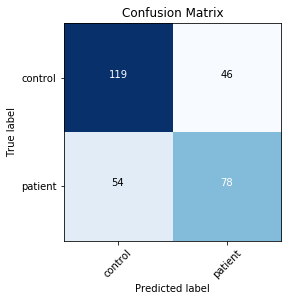

###### Starting inner fold 4
{'model': 'ModelLiu', 'batch_size': 12, 'patience': 12, 'lr': 0.0001}
Trainable model parameters: 116001
torch.Size([1, 72, 57, 75])


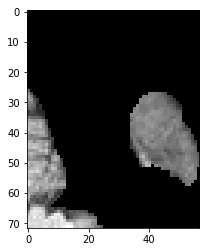

[0,    10] loss: 0.68929
[0,    20] loss: 0.69365
[0,    30] loss: 0.69965
[0,    40] loss: 0.69742
[0,    50] loss: 0.69298
[0,    60] loss: 0.69736
[0,    70] loss: 0.69287
[0,    80] loss: 0.69595
[0,    90] loss: 0.68636
Time elapsed: 0h:2m:9s
train accuracy_score: 51.10 %
train balanced_accuracy: 49.49 %
val accuracy_score: 55.56 %
val balanced_accuracy: 50.00 %
Val loss: 0.687410
[1,    10] loss: 0.69885
[1,    20] loss: 0.68127
[1,    30] loss: 0.70475
[1,    40] loss: 0.68502
[1,    50] loss: 0.69163
[1,    60] loss: 0.69528
[1,    70] loss: 0.69609
[1,    80] loss: 0.68846
[1,    90] loss: 0.69225
Time elapsed: 0h:6m:5s
train accuracy_score: 51.60 %
train balanced_accuracy: 49.39 %
[2,    10] loss: 0.68626
[2,    20] loss: 0.69555
[2,    30] loss: 0.69123
[2,    40] loss: 0.69128
[2,    50] loss: 0.69570
[2,    60] loss: 0.68773
[2,    70] loss: 0.69520
[2,    80] loss: 0.69111
[2,    90] loss: 0.69045
Time elapsed: 0h:8m:10s
train accuracy_score: 53.12 %
train balanced_accura

[25,    20] loss: 0.69222
[25,    30] loss: 0.69232
[25,    40] loss: 0.68692
[25,    50] loss: 0.70821
[25,    60] loss: 0.69555
[25,    70] loss: 0.68121
[25,    80] loss: 0.69003
[25,    90] loss: 0.68169
Time elapsed: 0h:54m:1s
train accuracy_score: 52.95 %
train balanced_accuracy: 52.72 %
[26,    10] loss: 0.69674
[26,    20] loss: 0.68216
[26,    30] loss: 0.68334
[26,    40] loss: 0.69975
[26,    50] loss: 0.69383
[26,    60] loss: 0.67129
[26,    70] loss: 0.69910
[26,    80] loss: 0.69484
[26,    90] loss: 0.69535
Time elapsed: 0h:55m:45s
train accuracy_score: 53.04 %
train balanced_accuracy: 51.93 %
[27,    10] loss: 0.68233
[27,    20] loss: 0.67298
[27,    30] loss: 0.70192
[27,    40] loss: 0.68157
[27,    50] loss: 0.69125
[27,    60] loss: 0.69262
[27,    70] loss: 0.68242
[27,    80] loss: 0.69187
[27,    90] loss: 0.69327
Time elapsed: 0h:57m:32s
train accuracy_score: 54.13 %
train balanced_accuracy: 53.32 %
[28,    10] loss: 0.67875
[28,    20] loss: 0.67224
[28,    3

[50,    20] loss: 0.67059
[50,    30] loss: 0.67727
[50,    40] loss: 0.65878
[50,    50] loss: 0.62923
[50,    60] loss: 0.68369
[50,    70] loss: 0.63389
[50,    80] loss: 0.63507
[50,    90] loss: 0.66263
Time elapsed: 1h:41m:45s
train accuracy_score: 61.80 %
train balanced_accuracy: 61.42 %
val accuracy_score: 64.65 %
val balanced_accuracy: 65.98 %
Val loss: 0.642651
[51,    10] loss: 0.66186
[51,    20] loss: 0.65271
[51,    30] loss: 0.66555
[51,    40] loss: 0.66753
[51,    50] loss: 0.65894
[51,    60] loss: 0.65256
[51,    70] loss: 0.62517
[51,    80] loss: 0.66458
[51,    90] loss: 0.63291
Time elapsed: 1h:45m:18s
train accuracy_score: 61.80 %
train balanced_accuracy: 61.50 %
[52,    10] loss: 0.67041
[52,    20] loss: 0.60368
[52,    30] loss: 0.64967
[52,    40] loss: 0.65175
[52,    50] loss: 0.67479
[52,    60] loss: 0.68018
[52,    70] loss: 0.64706
[52,    80] loss: 0.65910
[52,    90] loss: 0.68910
Time elapsed: 1h:47m:3s
train accuracy_score: 61.13 %
train balanced_a

[75,    10] loss: 0.62555
[75,    20] loss: 0.63858
[75,    30] loss: 0.58174
[75,    40] loss: 0.58124
[75,    50] loss: 0.64447
[75,    60] loss: 0.64700
[75,    70] loss: 0.62568
[75,    80] loss: 0.65151
[75,    90] loss: 0.60284
Time elapsed: 2h:31m:29s
train accuracy_score: 63.07 %
train balanced_accuracy: 62.78 %
[76,    10] loss: 0.57828
[76,    20] loss: 0.61428
[76,    30] loss: 0.59687
[76,    40] loss: 0.60646
[76,    50] loss: 0.67341
[76,    60] loss: 0.62043
[76,    70] loss: 0.61701
[76,    80] loss: 0.59323
[76,    90] loss: 0.59360
Time elapsed: 2h:33m:17s
train accuracy_score: 67.45 %
train balanced_accuracy: 67.19 %
[77,    10] loss: 0.57175
[77,    20] loss: 0.55581
[77,    30] loss: 0.60534
[77,    40] loss: 0.62189
[77,    50] loss: 0.59564
[77,    60] loss: 0.61066
[77,    70] loss: 0.66949
[77,    80] loss: 0.61815
[77,    90] loss: 0.58687
Time elapsed: 2h:35m:6s
train accuracy_score: 66.44 %
train balanced_accuracy: 66.16 %
[78,    10] loss: 0.61196
[78,    2

[100,    10] loss: 0.62462
[100,    20] loss: 0.61420
[100,    30] loss: 0.56663
[100,    40] loss: 0.65522
[100,    50] loss: 0.60415
[100,    60] loss: 0.58500
[100,    70] loss: 0.59507
[100,    80] loss: 0.60924
[100,    90] loss: 0.55412
Time elapsed: 3h:19m:33s
train accuracy_score: 66.69 %
train balanced_accuracy: 66.50 %
val accuracy_score: 68.35 %
val balanced_accuracy: 68.48 %
Val loss: 0.582262
[101,    10] loss: 0.58735
[101,    20] loss: 0.66673
[101,    30] loss: 0.56567
[101,    40] loss: 0.59860
[101,    50] loss: 0.58950
[101,    60] loss: 0.59143
[101,    70] loss: 0.57114
[101,    80] loss: 0.60819
[101,    90] loss: 0.58833
Time elapsed: 3h:23m:2s
train accuracy_score: 66.95 %
train balanced_accuracy: 66.72 %
[102,    10] loss: 0.55018
[102,    20] loss: 0.62558
[102,    30] loss: 0.65662
[102,    40] loss: 0.61877
[102,    50] loss: 0.61427
[102,    60] loss: 0.57440
[102,    70] loss: 0.58553
[102,    80] loss: 0.53587
[102,    90] loss: 0.62760
Time elapsed: 3h:2

[124,    20] loss: 0.57788
[124,    30] loss: 0.58667
[124,    40] loss: 0.60609
[124,    50] loss: 0.57123
[124,    60] loss: 0.56938
[124,    70] loss: 0.62711
[124,    80] loss: 0.57989
[124,    90] loss: 0.58013
Time elapsed: 4h:7m:58s
train accuracy_score: 68.72 %
train balanced_accuracy: 68.46 %
[125,    10] loss: 0.60348
[125,    20] loss: 0.60635
[125,    30] loss: 0.58345
[125,    40] loss: 0.55542
[125,    50] loss: 0.63065
[125,    60] loss: 0.60890
[125,    70] loss: 0.54898
[125,    80] loss: 0.58234
[125,    90] loss: 0.60749
Time elapsed: 4h:9m:48s
train accuracy_score: 68.97 %
train balanced_accuracy: 68.80 %
[126,    10] loss: 0.55119
[126,    20] loss: 0.60184
[126,    30] loss: 0.56855
[126,    40] loss: 0.58391
[126,    50] loss: 0.58329
[126,    60] loss: 0.57029
[126,    70] loss: 0.66134
[126,    80] loss: 0.55402
[126,    90] loss: 0.53117
Time elapsed: 4h:11m:41s
train accuracy_score: 69.65 %
train balanced_accuracy: 69.45 %
[127,    10] loss: 0.56480
[127,    

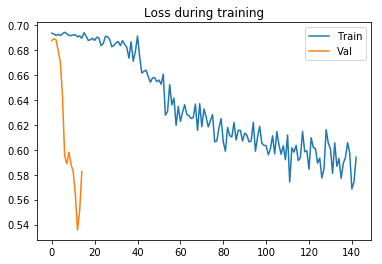

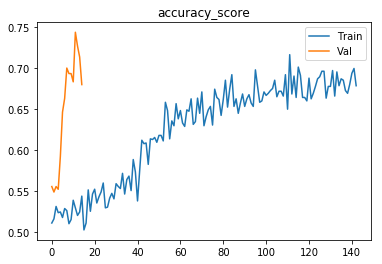

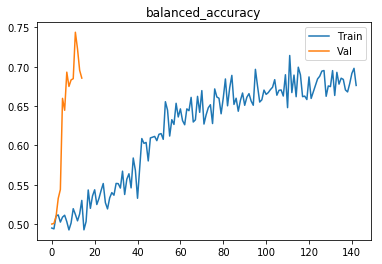

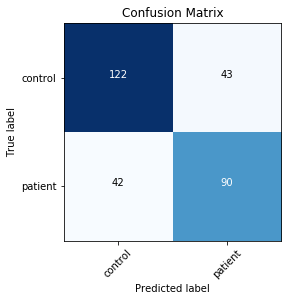

Finished outer fold.
{'final_acc': 0.68560606060606055, 'best_acc': 0.7439393939393939, 'final_iter': 15, 'best_iter': 12, 'params': {'model': 'ModelLiu', 'batch_size': 12, 'patience': 12, 'lr': 0.0001}, 'inner_fold_idx': 4}
################################
################################
All accuracies: [0.59506172839506166, 0.68703703703703711, 0.67345679012345672, 0.68086419753086425, 0.68518518518518512, 0.6333333333333333, 0.65530303030303028, 0.6803030303030303, 0.64924242424242429, 0.68560606060606055]
Best accuracies mean: 0.6486792929292929 All :[0.62549382716049384, 0.66790123456790129, 0.65499999999999992, 0.63907407407407413, 0.6869753086419752, 0.6360606060606061, 0.61886363636363639, 0.64333333333333331, 0.62522727272727274, 0.68886363636363634]
[{'final_acc': 0.68703703703703711, 'best_acc': 0.75864197530864197, 'final_iter': 15, 'best_iter': 11, 'params': {'model': 'ModelLiu', 'batch_size': 32, 'patience': 12, 'lr': 0.0001}, 'inner_fold_idx': 1}, {'final_acc': 0.685606

In [24]:
fold_metric, models = run(net=None, data=df,
                  k_folds=-1,
                  callbacks=None,
                  shape=-1,
                  masked=False,
                  metrics=metrics,
                  num_epochs=num_epochs,
                  retain_metric=retain_metric,
                  augmentations=augmentations,
                  b=None
                 )

print(np.mean(fold_metric))
print(np.std(fold_metric))

In [25]:
5/0

ZeroDivisionError: division by zero

In [27]:
training_res = [{'final_acc': 0.68703703703703711, 'best_acc': 0.75864197530864197, 'final_iter': 15, 'best_iter': 11, 'params': {'model': 'ModelLiu', 'batch_size': 32, 'patience': 12, 'lr': 0.0001}, 'inner_fold_idx': 1}, {'final_acc': 0.68560606060606055, 'best_acc': 0.7439393939393939, 'final_iter': 15, 'best_iter': 12, 'params': {'model': 'ModelLiu', 'batch_size': 12, 'patience': 12, 'lr': 0.0001}, 'inner_fold_idx': 4}]

In [28]:
training_res

[{'best_acc': 0.758641975308642,
  'best_iter': 11,
  'final_acc': 0.6870370370370371,
  'final_iter': 15,
  'inner_fold_idx': 1,
  'params': {'batch_size': 32,
   'lr': 0.0001,
   'model': 'ModelLiu',
   'patience': 12}},
 {'best_acc': 0.7439393939393939,
  'best_iter': 12,
  'final_acc': 0.6856060606060606,
  'final_iter': 15,
  'inner_fold_idx': 4,
  'params': {'batch_size': 12,
   'lr': 0.0001,
   'model': 'ModelLiu',
   'patience': 12}}]

In [54]:
!ls $output_dir

outer_0_inner_0_cv_fold_0_BEST_ITERATION.h5
outer_0_inner_0_cv_fold_0_training_epoch_178_FINAL.h5
outer_0_inner_1_cv_fold_1_BEST_ITERATION.h5
outer_0_inner_1_cv_fold_1_training_epoch_144_FINAL.h5
outer_0_inner_2_cv_fold_2_BEST_ITERATION.h5
outer_0_inner_2_cv_fold_2_training_epoch_168_FINAL.h5
outer_0_inner_3_cv_fold_3_BEST_ITERATION.h5
outer_0_inner_3_cv_fold_3_training_epoch_154_FINAL.h5
outer_0_inner_4_cv_fold_4_BEST_ITERATION.h5
outer_0_inner_4_cv_fold_4_training_epoch_168_FINAL.h5
outer_1_inner_0_cv_fold_5_BEST_ITERATION.h5
outer_1_inner_0_cv_fold_5_training_epoch_144_FINAL.h5
outer_1_inner_1_cv_fold_6_BEST_ITERATION.h5
outer_1_inner_1_cv_fold_6_training_epoch_158_FINAL.h5
outer_1_inner_2_cv_fold_7_BEST_ITERATION.h5
outer_1_inner_2_cv_fold_7_training_epoch_144_FINAL.h5
outer_1_inner_3_cv_fold_8_BEST_ITERATION.h5
outer_1_inner_3_cv_fold_8_training_epoch_154_FINAL.h5
outer_1_inner_4_cv_fold_9_BEST_ITERATION.h5
outer_1_inner_4_cv_fold_9_training_epoch_144_FINAL.h5


# Start inference

In [49]:
from collections import OrderedDict, Counter
from itertools import product

### Use majority vote of all patches to select prediction

In [52]:
def majority_vote_patches(img, net, gpu):
    # forward each patch per subject
    patch_preds = []
    avg_score = 0
    for i in range(img.shape[2]):
        patch = img[:,:,i].to(torch.device("cuda:" + str(gpu)))
        patch_output = net.forward(patch)
        patch_score = torch.sigmoid(patch_output)
        patch_pred = patch_score >= 0.5
        patch_preds.append(patch_pred.cpu().numpy().item())
        avg_score += patch_score.cpu().numpy().item()
    # take vote of predictions
    pred = Counter(patch_preds).most_common(1)[0][0]
    avg_score /= img.shape[2]
    return pred, avg_score

In [53]:
metrics = []
random_states = np.arange(20, 22) # important to use the same values as during training
maj_vote = True

for outer_fold, r in enumerate(random_states):
    print("Outer fold {}".format(outer_fold))

    all_scores = []
    all_preds = []
    all_labels = []
    
    train_res = training_res[outer_fold]
    model_dir = os.path.join(output_dir,"outer_{}_inner_{}_cv_fold_{}_BEST_ITERATION.h5".format(outer_fold, train_res["inner_fold_idx"], outer_fold * 5 + train_res["inner_fold_idx"]))
    model_name = train_res["params"]["model"]
    net = pick_model(model_name)
    state_dict = torch.load(model_dir, map_location='cpu')
    new_state_dict = OrderedDict()
    for param in state_dict.items():
        new_state_dict.update([(param[0].replace("module.", ""), param[1])])
    
    net.load_state_dict(new_state_dict)
    net = net.cuda(gpu)
    net.eval()
    
    # load data
    # separate new test set each run
    no_test_df = df.sample(frac=0.8, random_state=r) # split according 
    test_df = df[~df["PTID"].isin(no_test_df["PTID"])]

    if zero_one_normalize:
        intensity = IntensityRescale()
        ukb_data_test = UKBGDataset(test_df, transform=transforms.Compose([intensity]), mask=mask, patched=True, all_locs=True)
    else:
        ukb_data_test = UKBGDataset(test_df, transform=None, mask=mask, patched=True, all_locs=True)
        
    test_loader = DataLoader(
            ukb_data_test, batch_size=1, num_workers=0, shuffle=False
    )
    
    with torch.no_grad():
        for sample in test_loader:
            img = sample["image"]
            label = sample["label"]
            
            if maj_vote:
                pred, score = majority_vote_patches(img, net, gpu)
            else:
                img = img.to(torch.device("cuda:" + str(gpu)))
                output = net.forward(img)
                score = torch.sigmoid(output)
                pred = score >= 0.5
                score = score.numpy().item()
                pred = pred.numpy().item()
            
            all_scores.append(score)
            all_preds.append(pred)
            all_labels.append(label.numpy().item())
    
    balanced_acc = balanced_accuracy(all_labels, all_preds)
    roc_score = roc_auc_score(all_labels, all_scores)
    sens = sensitivity(all_labels, all_preds)
    spec = specificity(all_labels, all_preds)
    print("Bal. accuracy {:.3f} %".format(balanced_acc*100))
    print("ROC AUC Score {:.3f} %".format(roc_score*100))
    print("Sensitivity {:.3f} %".format(sens*100))
    print("Specificity {:.3f} %".format(spec*100))
    metrics.append([balanced_acc, roc_score, sens, spec])
# reset network to training mode6
net.train()
print("######## Final results ########")
metrics_df = pd.DataFrame(metrics, columns=["Bal Acc", "ROC AUC", "Sensitivity", "Specificity"])
print(metrics_df)
print("Balanced accuracy mean {:.3f} %".format(np.mean(metrics_df["Bal Acc"])*100))
print("ROC AUC mean {:.3f} %".format(np.mean(metrics_df["ROC AUC"])*100))
print("Sensitivity mean {:.3f} %".format(np.mean(metrics_df["Sensitivity"])*100))
print("Specificity mean {:.3f} %".format(np.mean(metrics_df["Specificity"])*100))

Outer fold 0


/home/fabiane/anaconda2/envs/mort1/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Bal. accuracy 68.857 %
ROC AUC Score 77.708 %
Sensitivity 66.860 %
Specificity 70.854 %
Outer fold 1
Bal. accuracy 74.652 %
ROC AUC Score 81.118 %
Sensitivity 65.359 %
Specificity 83.945 %
######## Final results ########
    Bal Acc   ROC AUC  Sensitivity  Specificity
0  0.688574  0.777083     0.668605     0.708543
1  0.746522  0.811177     0.653595     0.839450
Balanced accuracy mean 71.755 %
ROC AUC mean 79.413 %
Sensitivity mean 66.110 %
Specificity mean 77.400 %
